# Problem Set 2 Q2




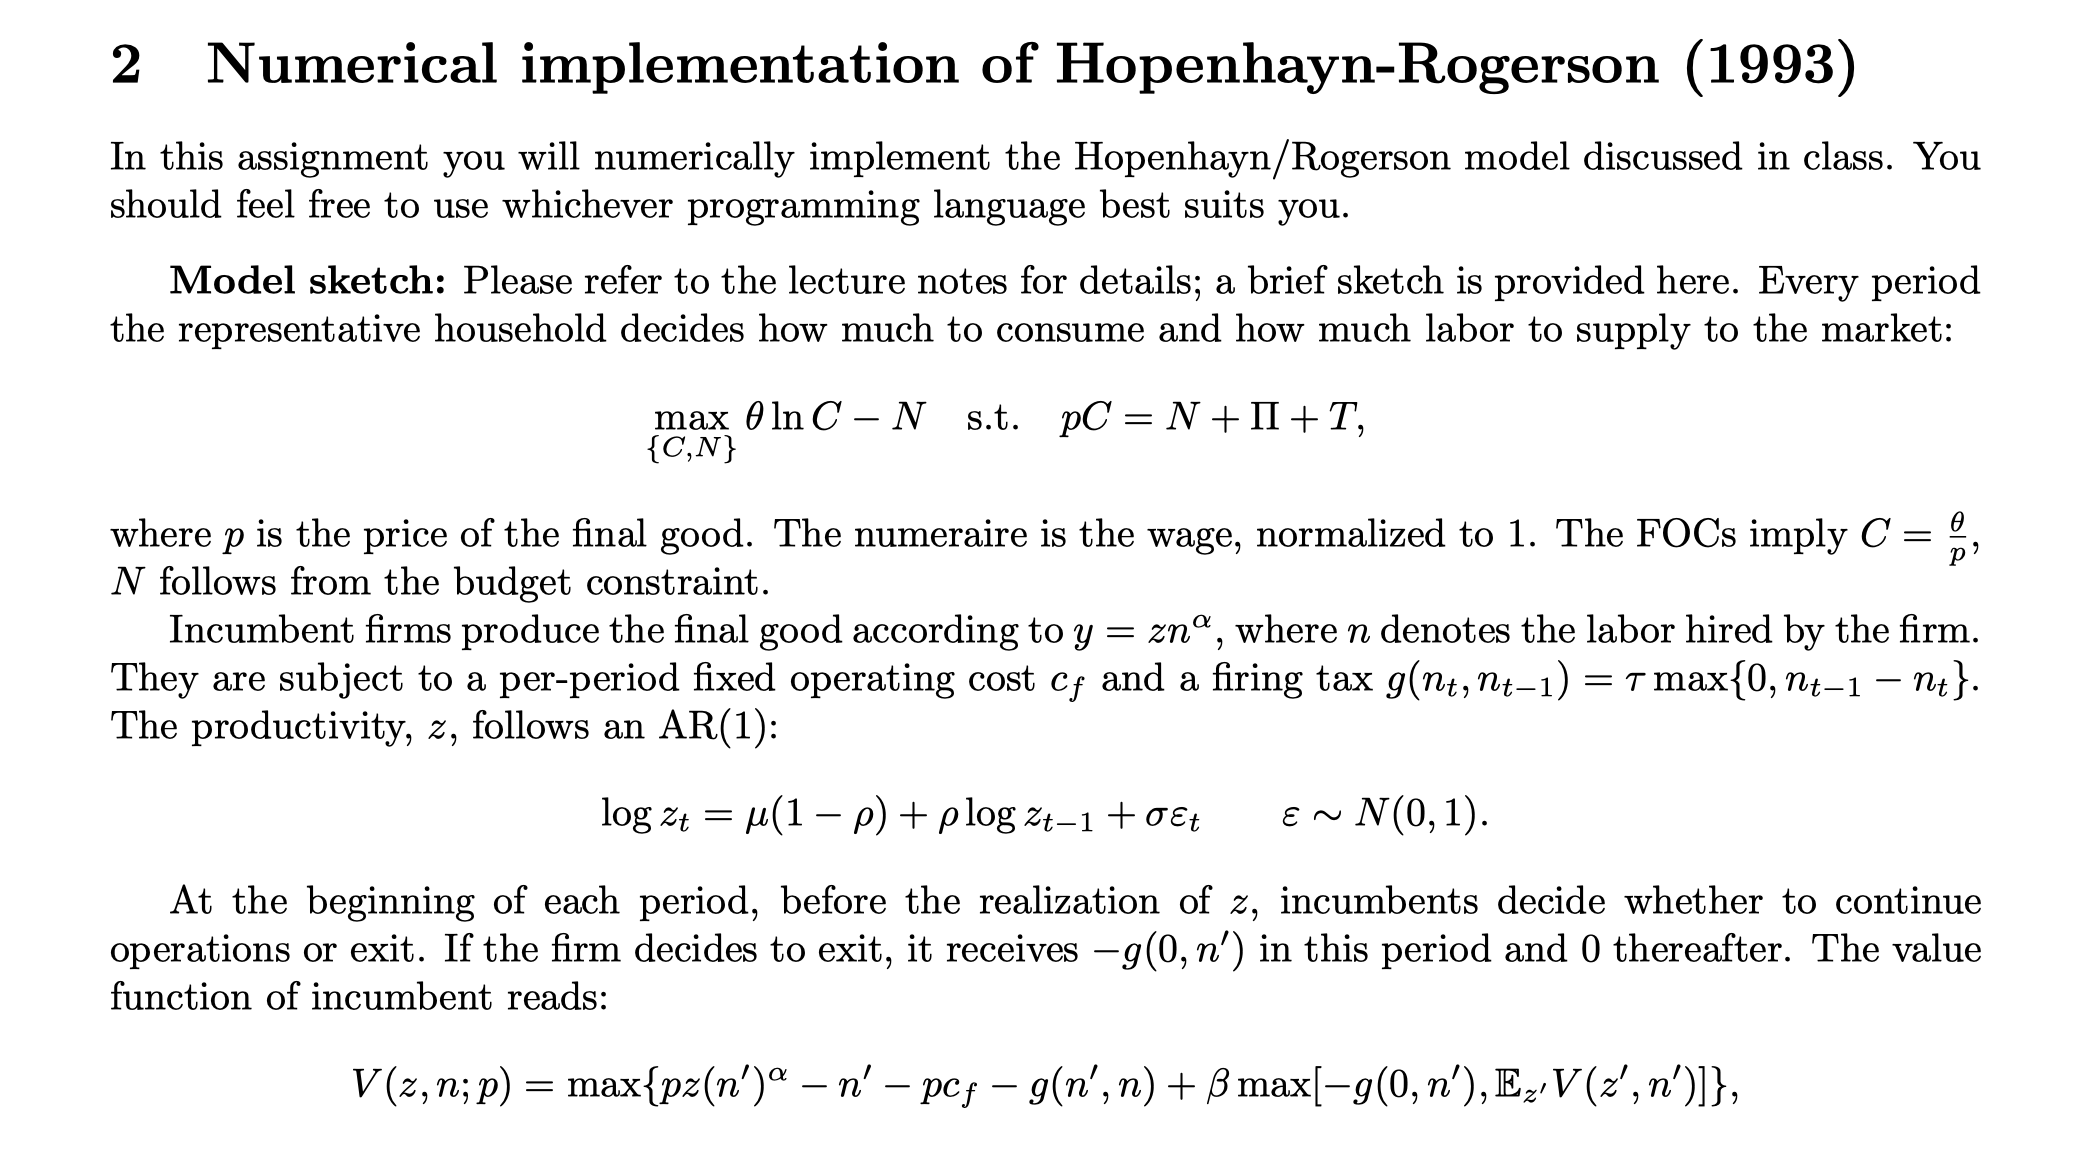


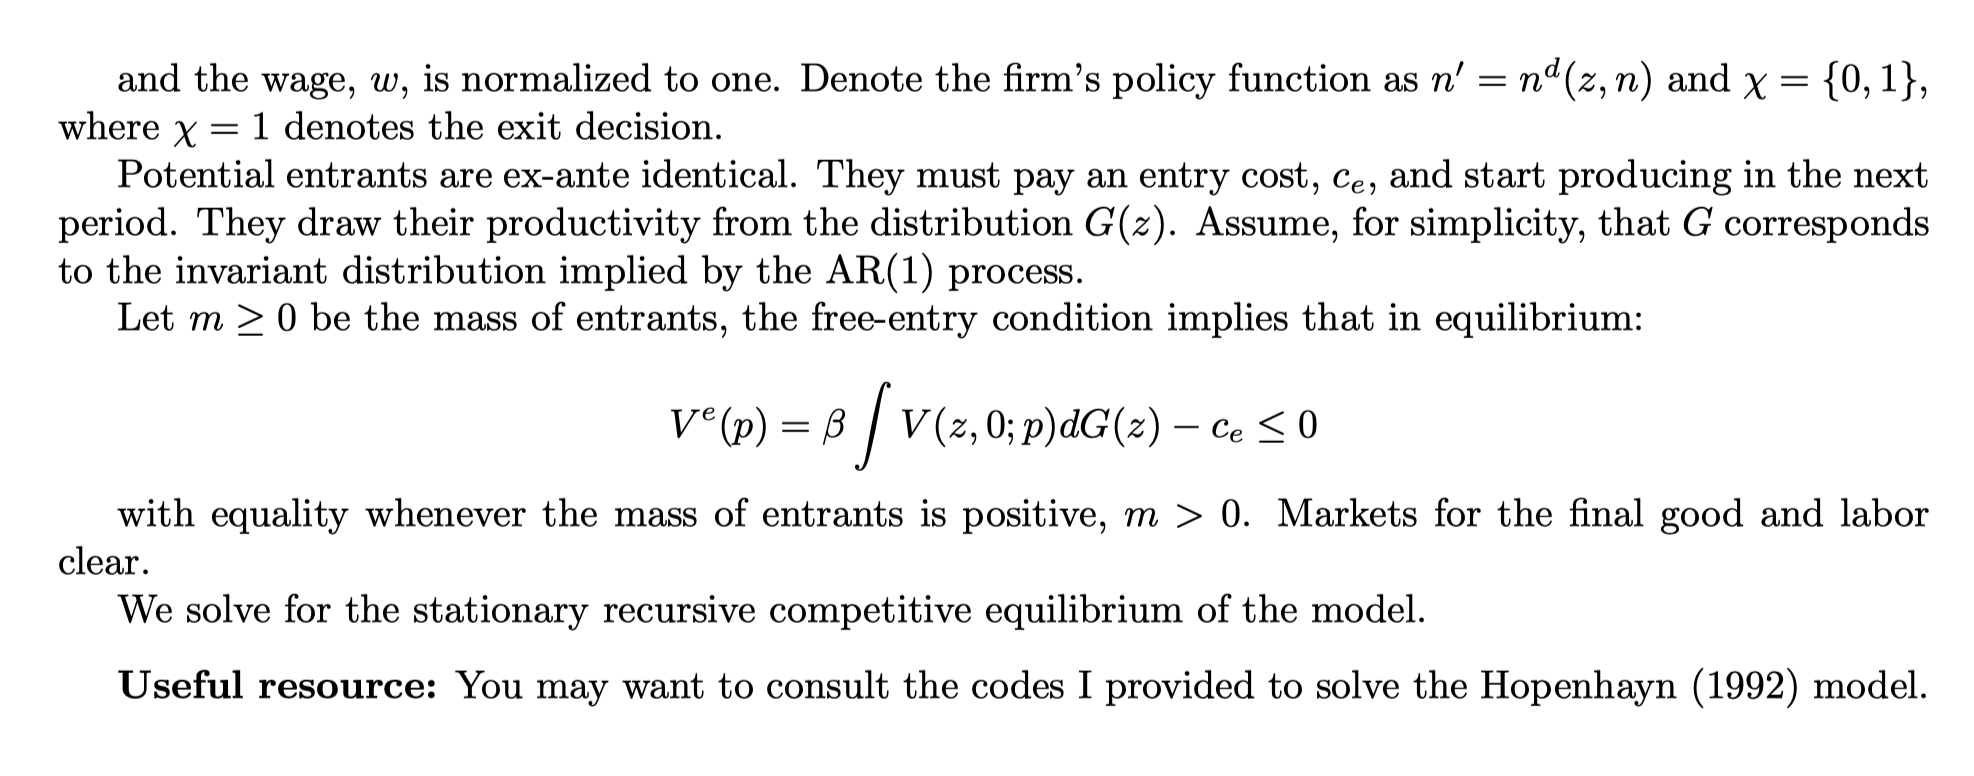



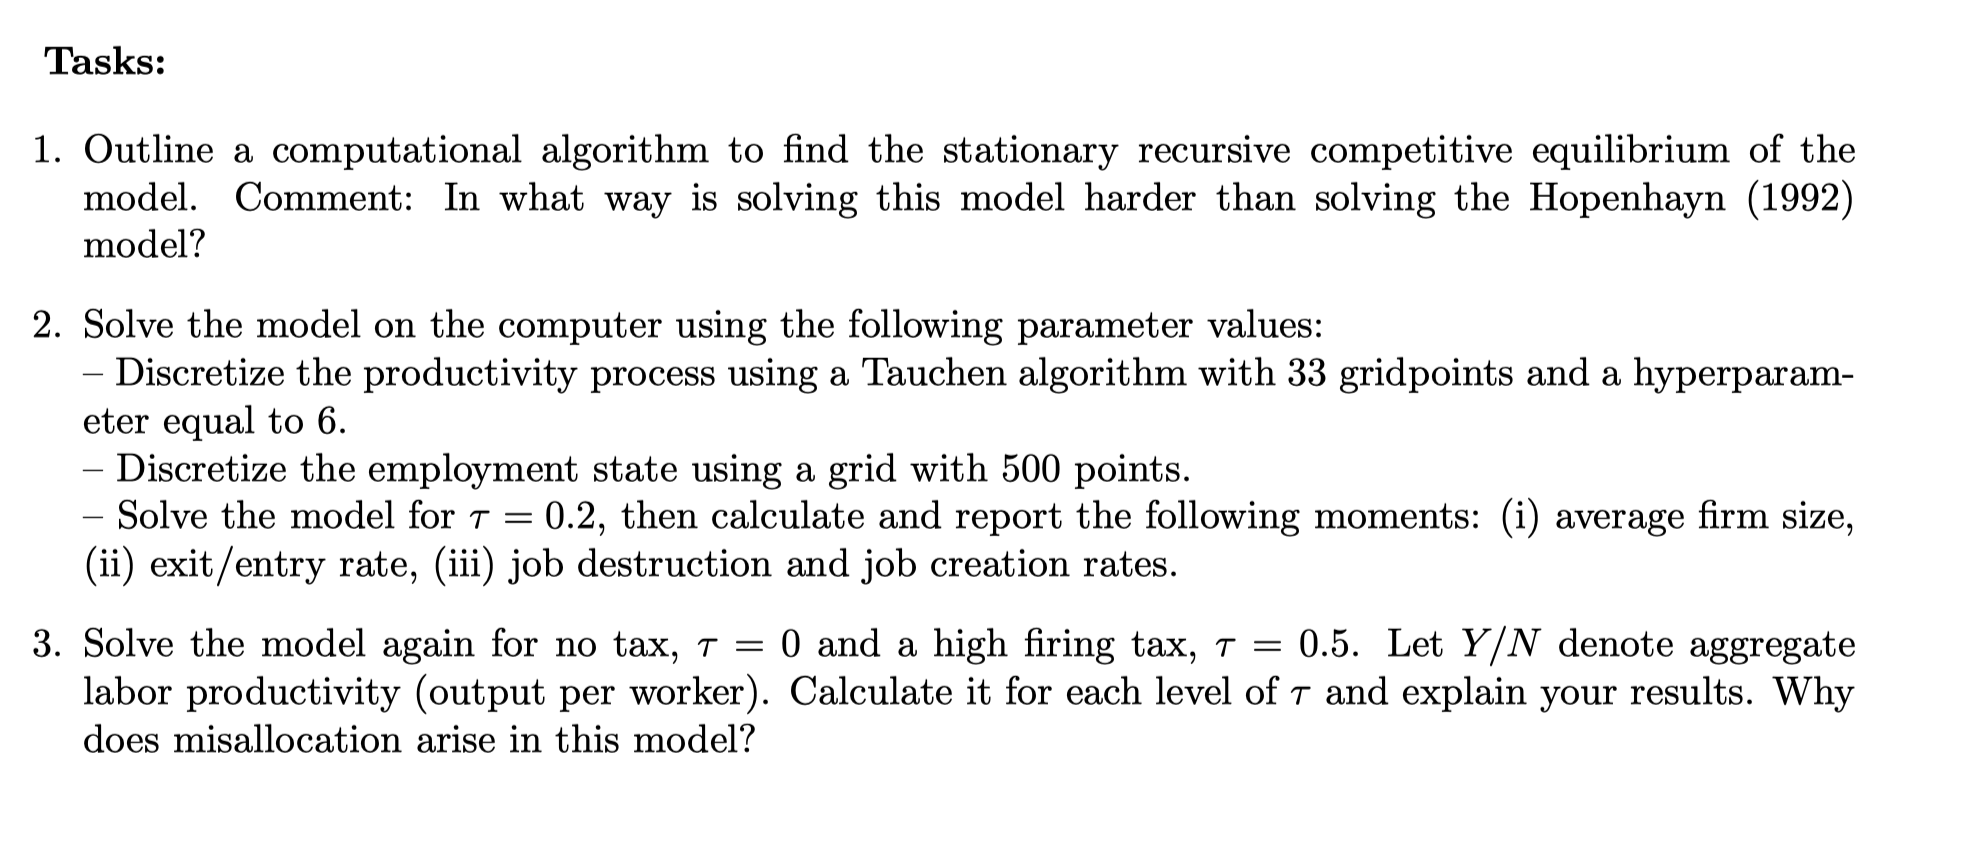




# Lecture Notes


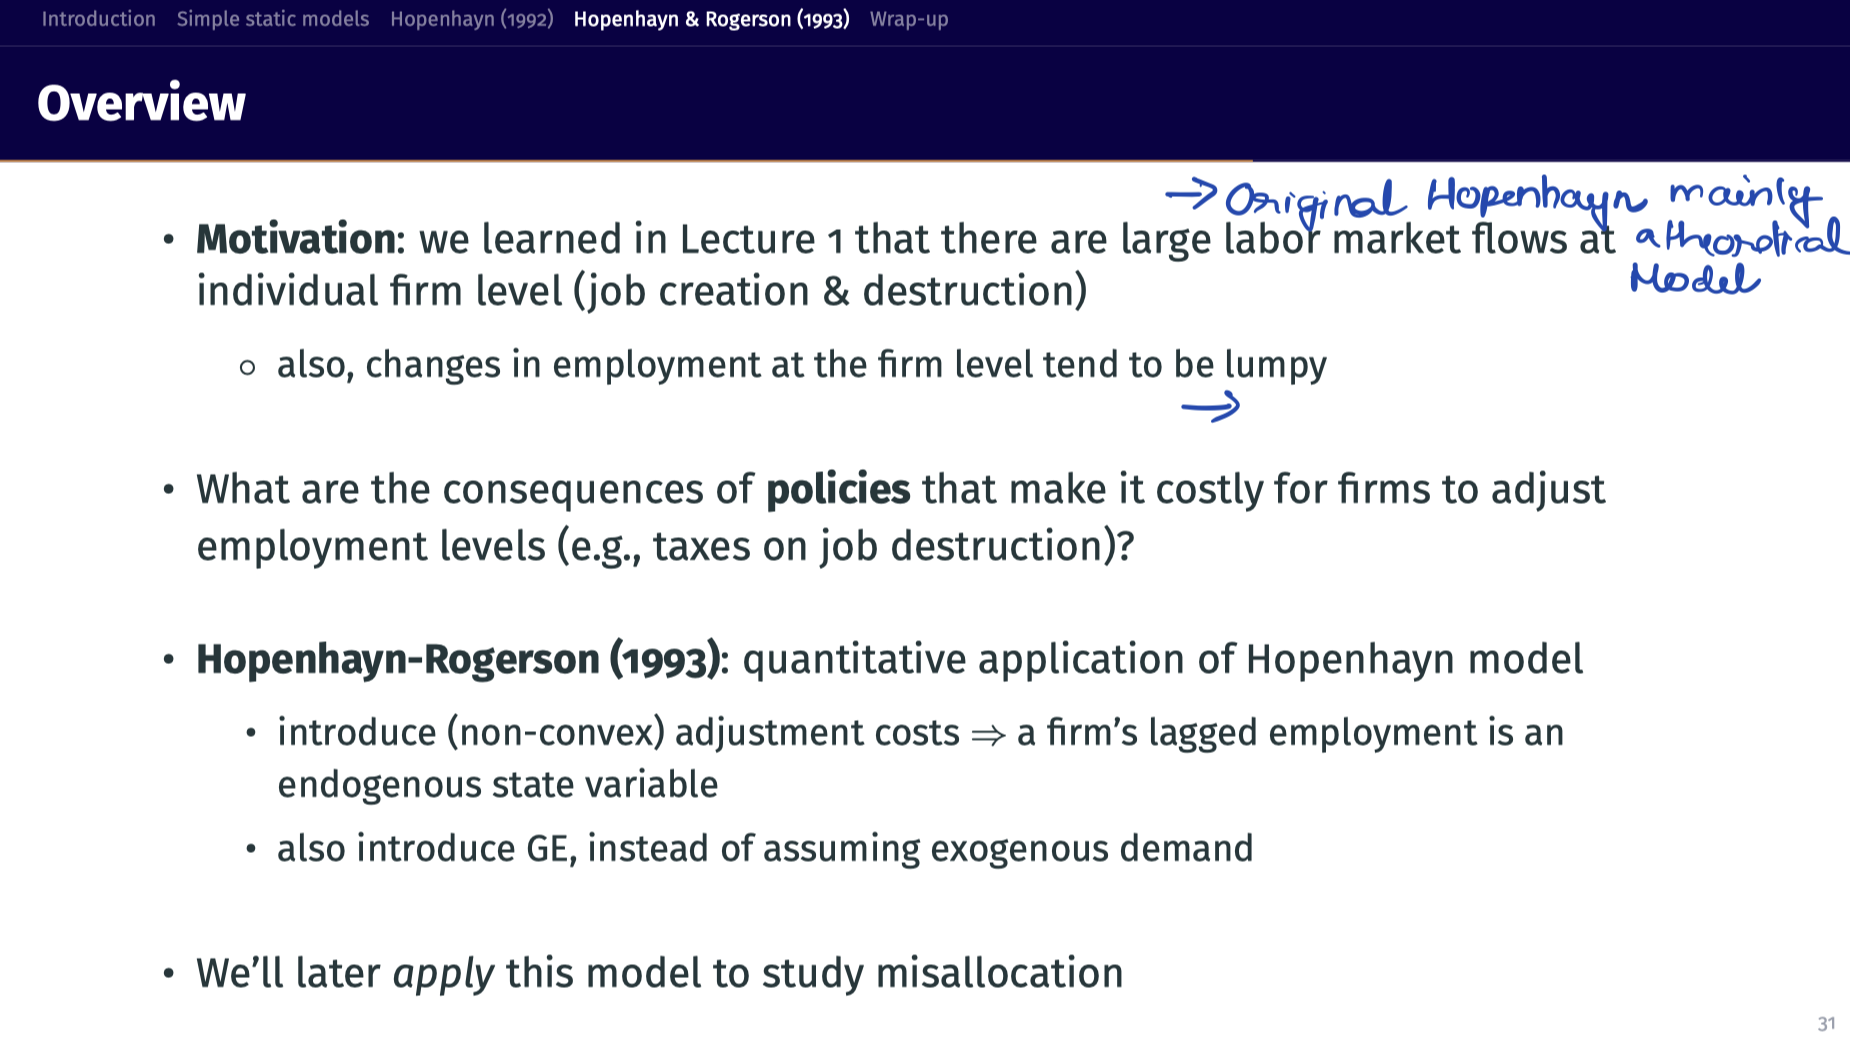


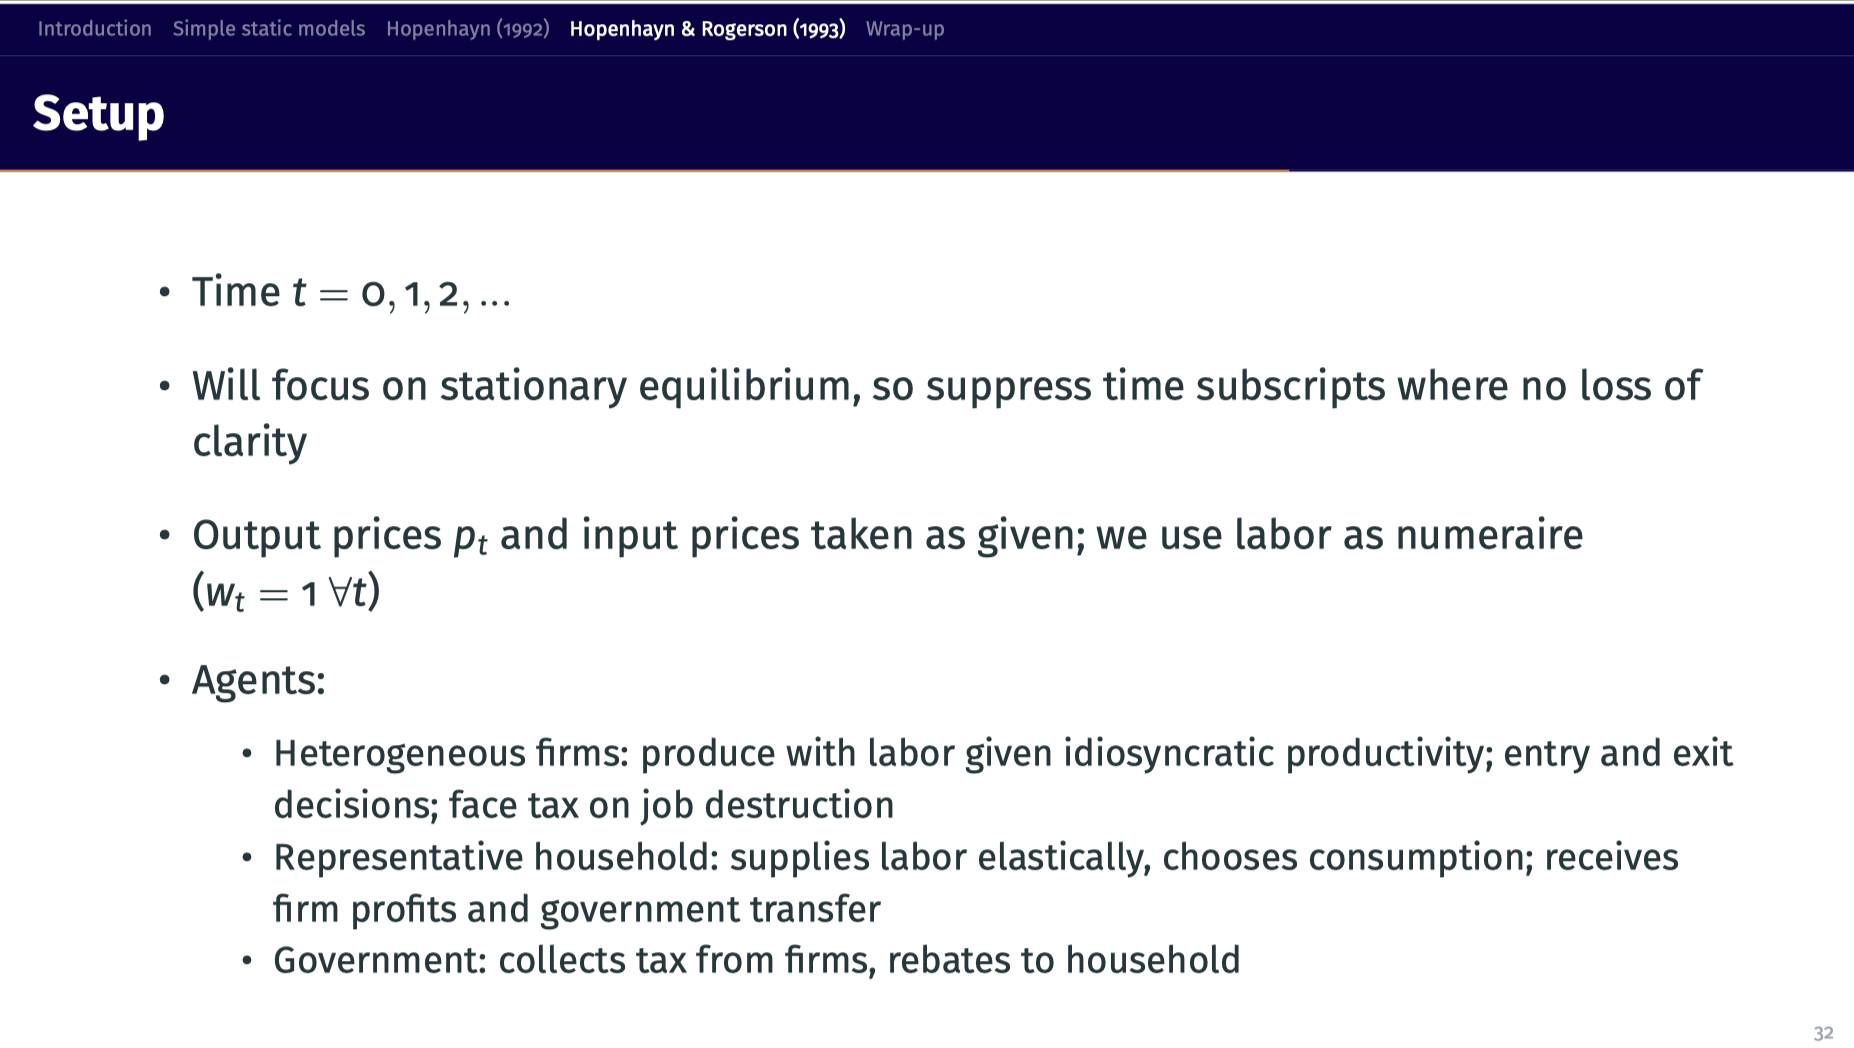



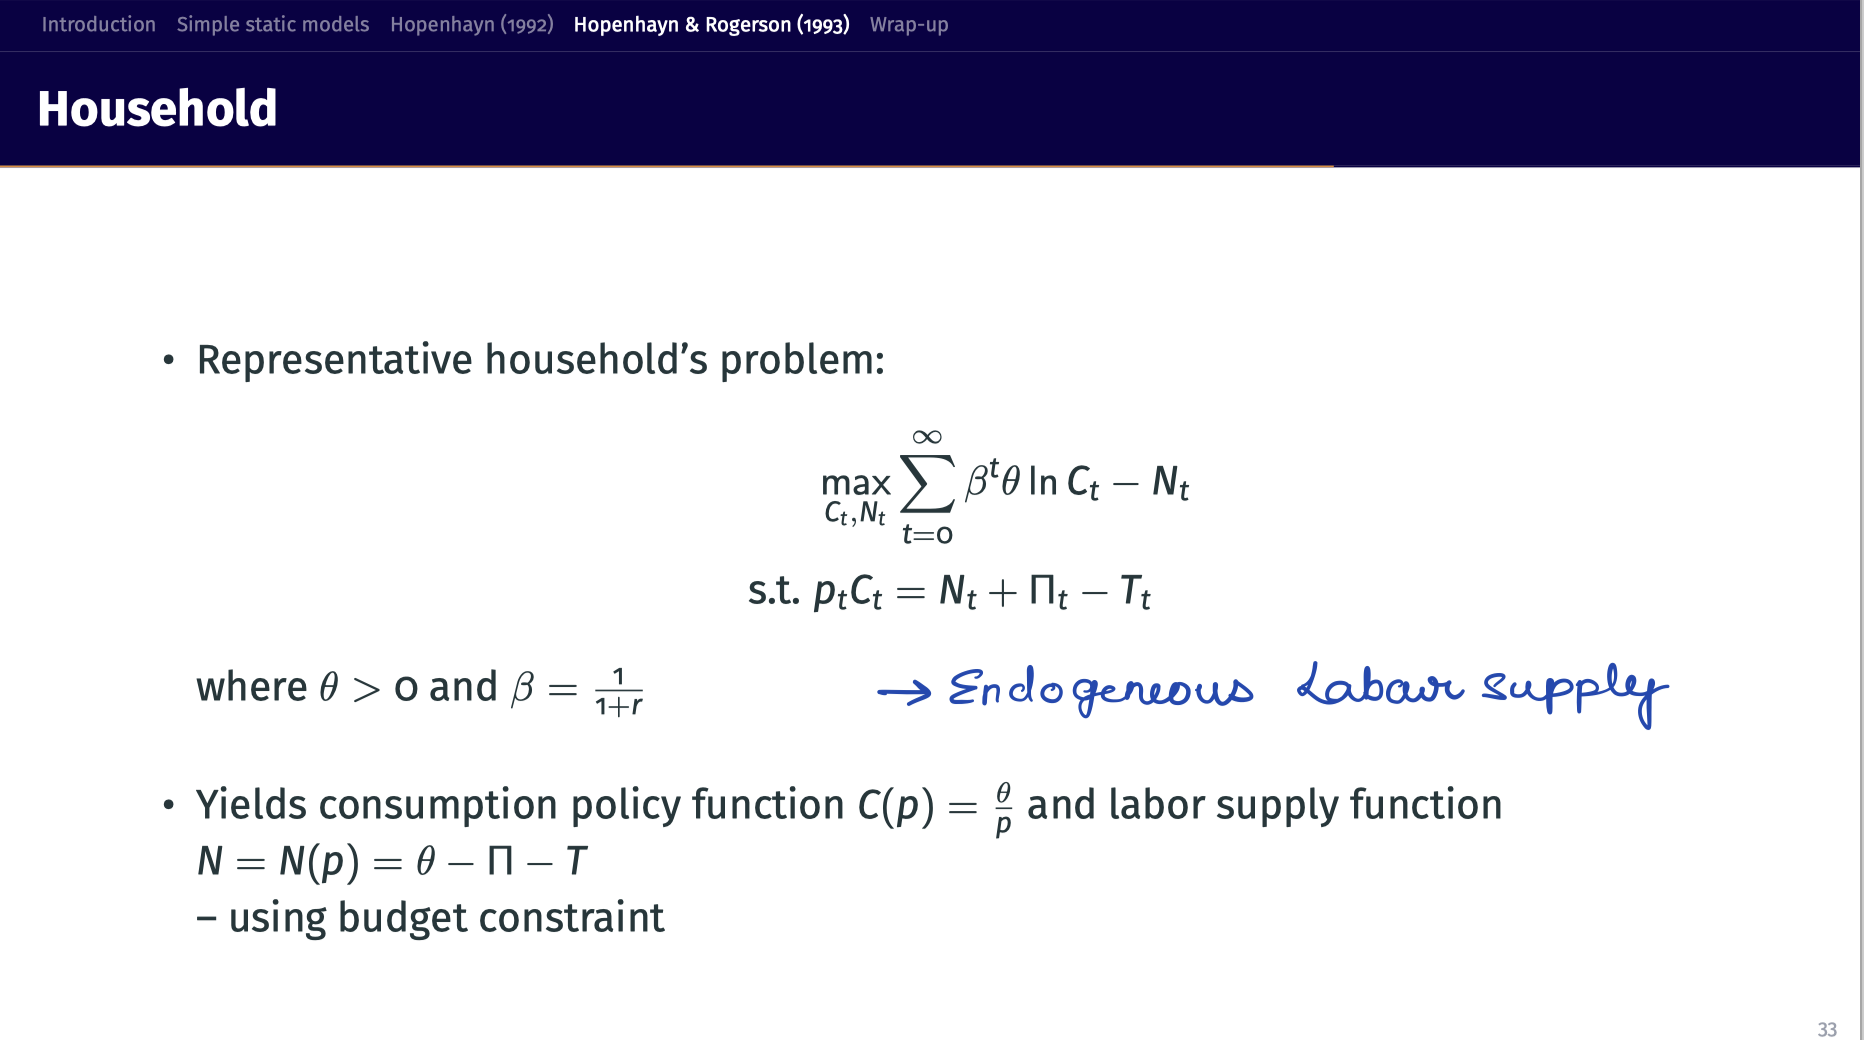



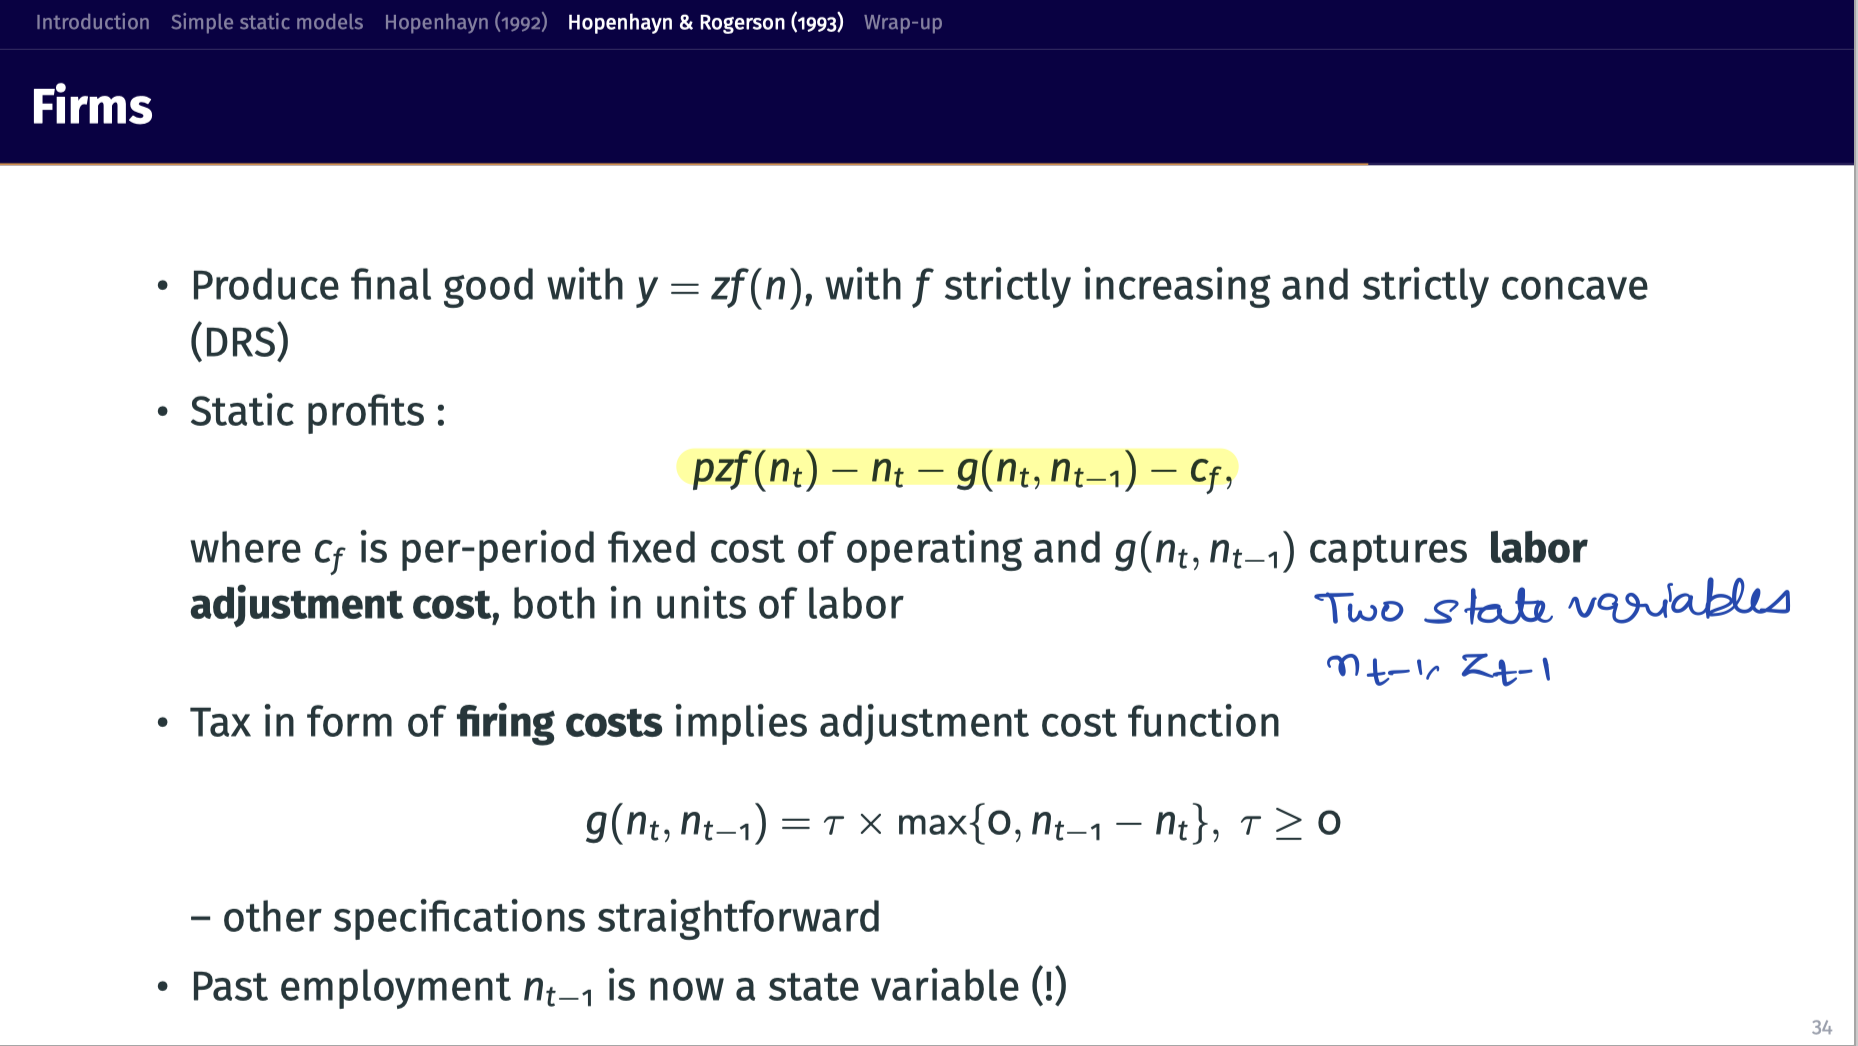


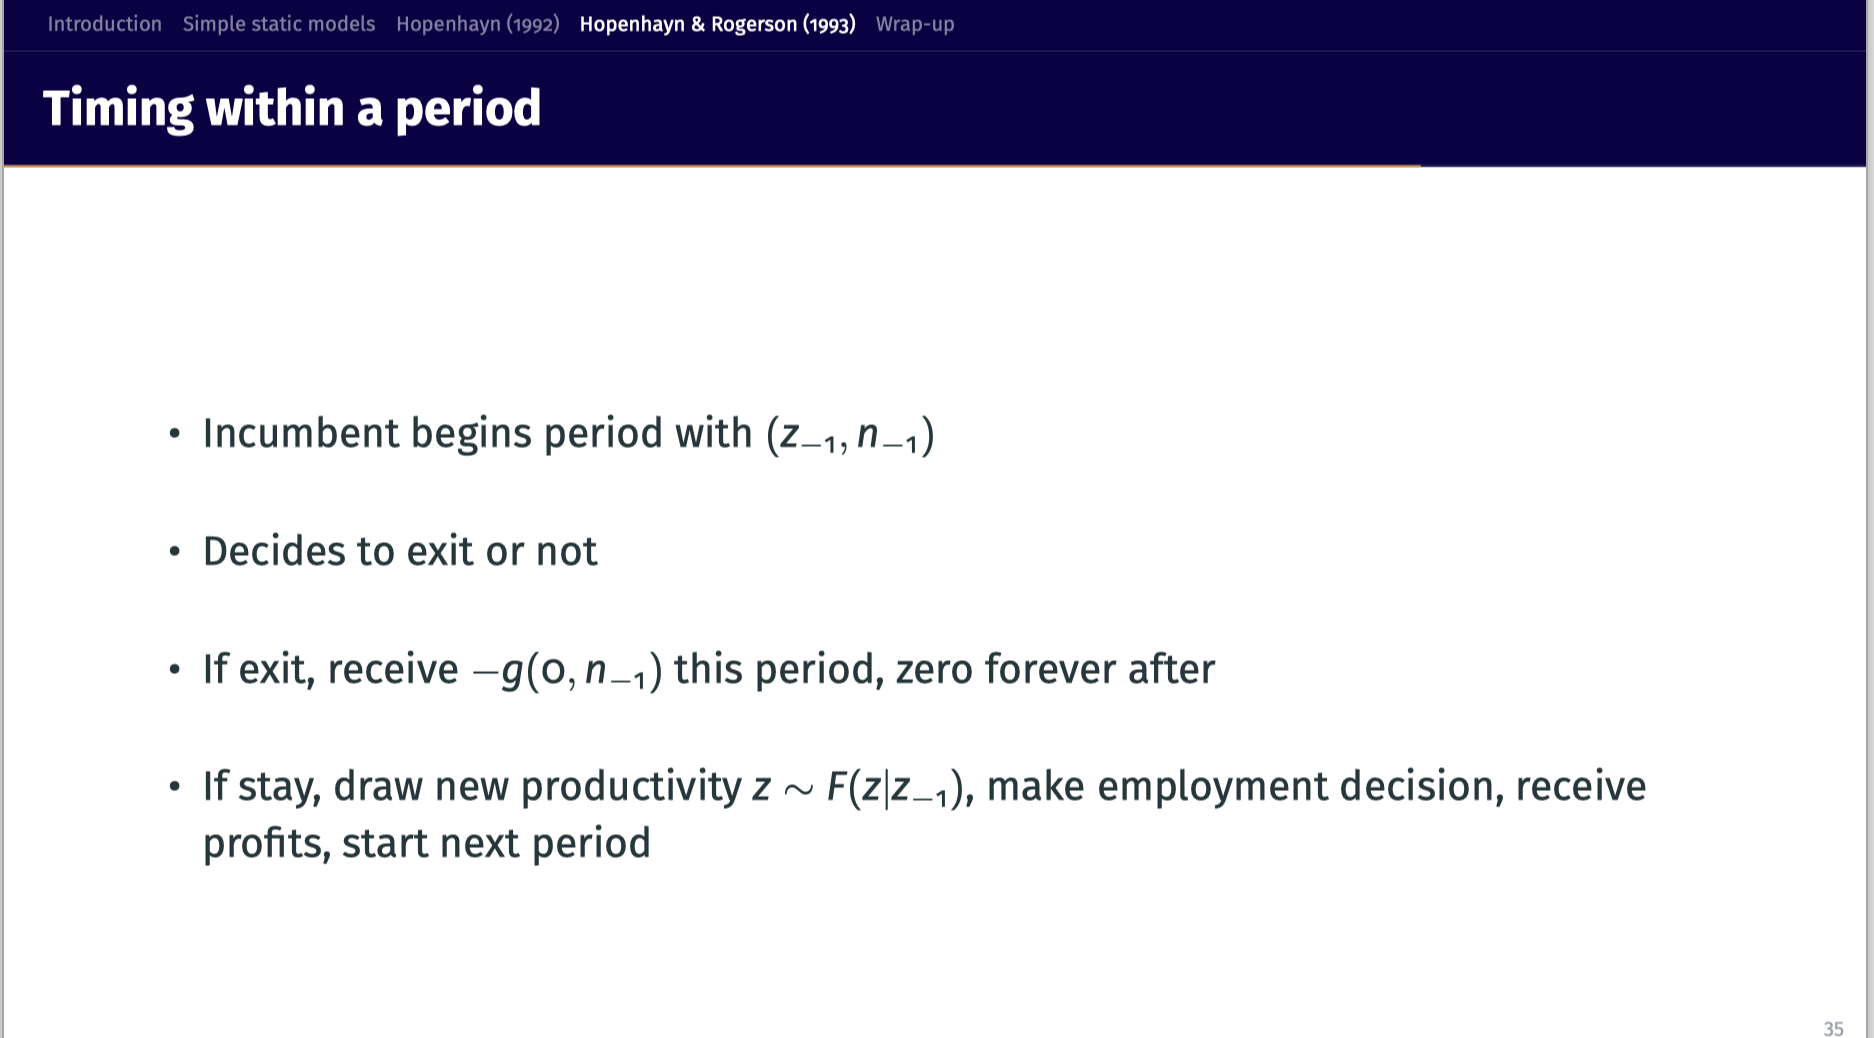



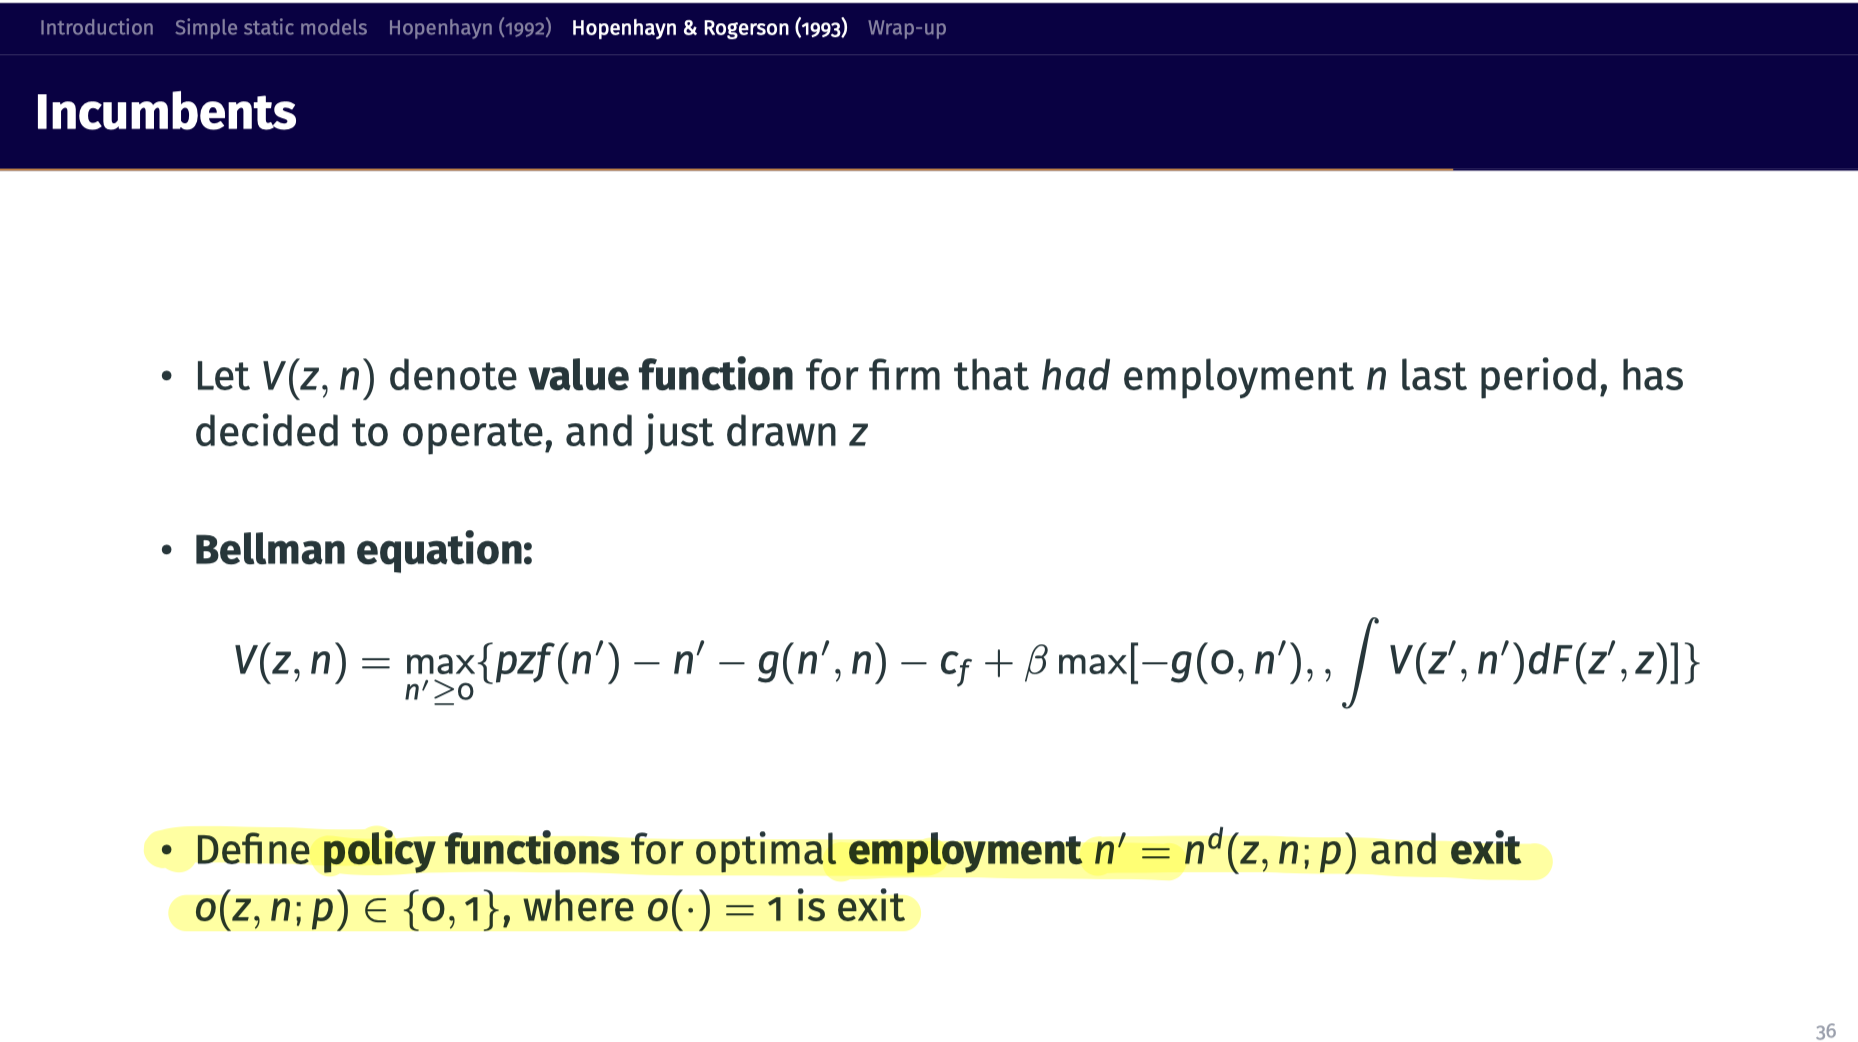



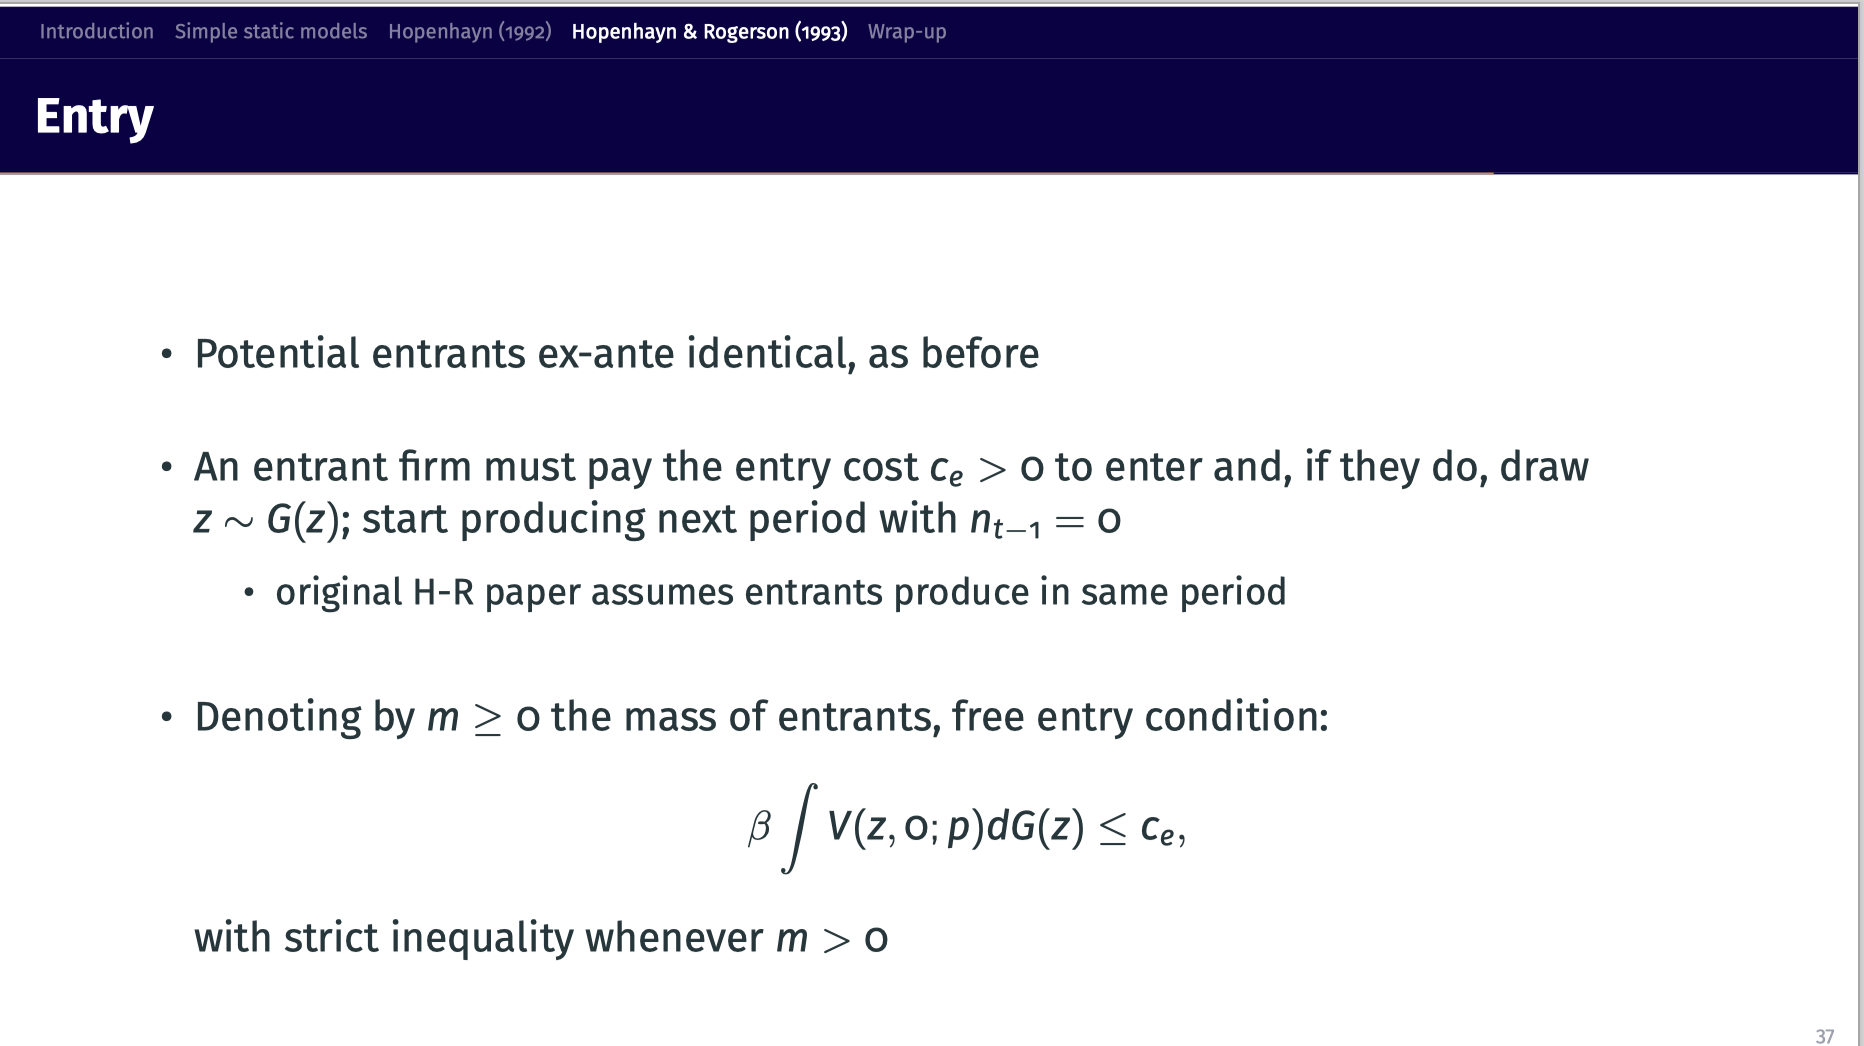


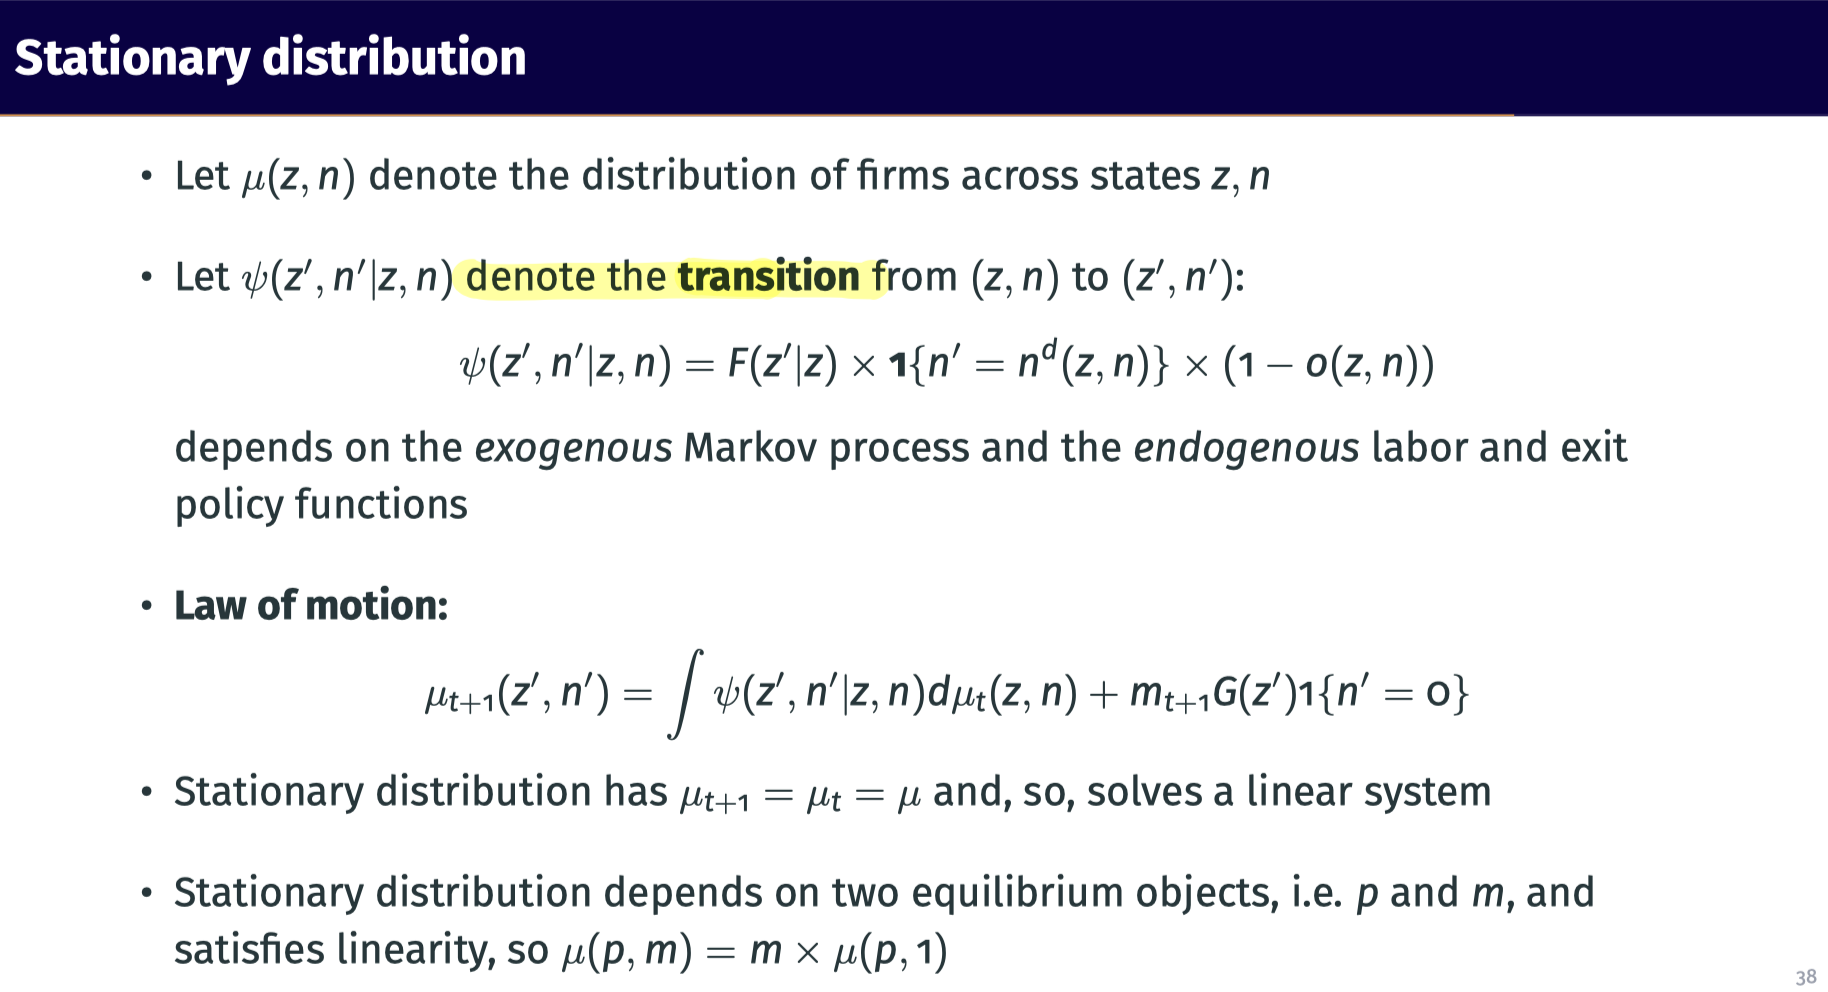



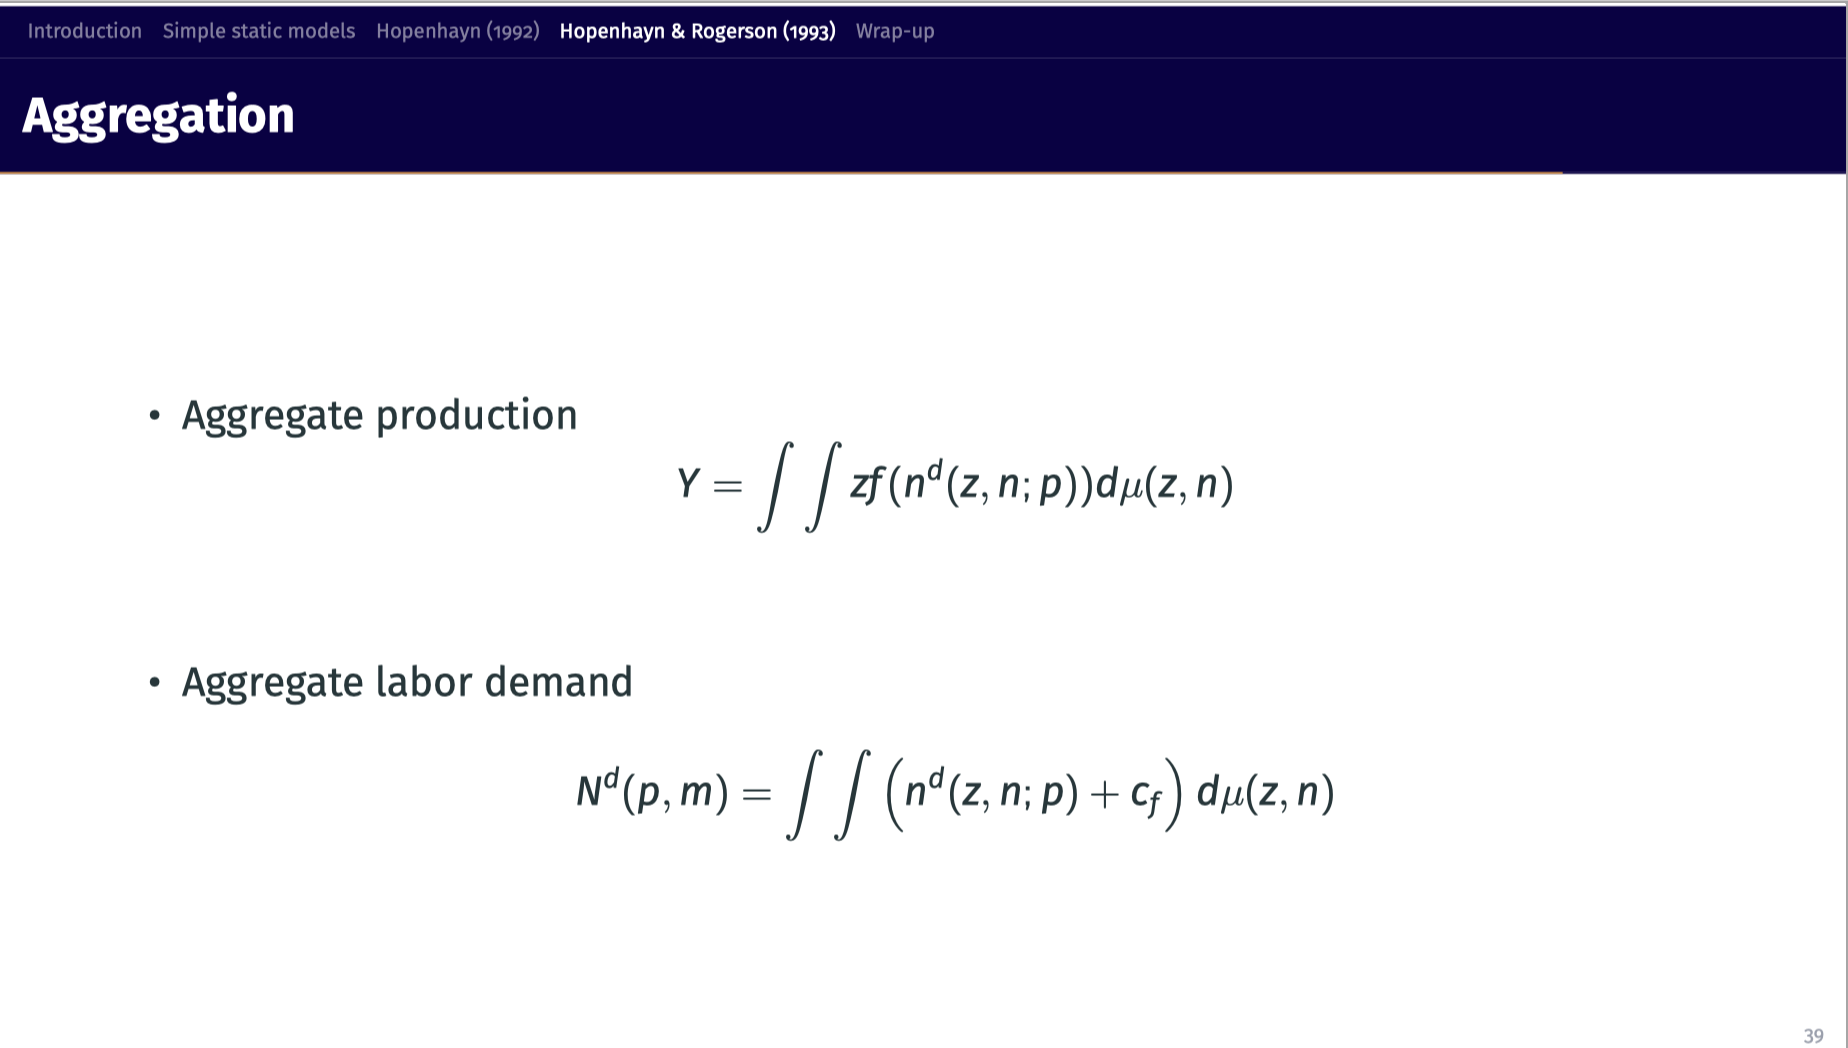



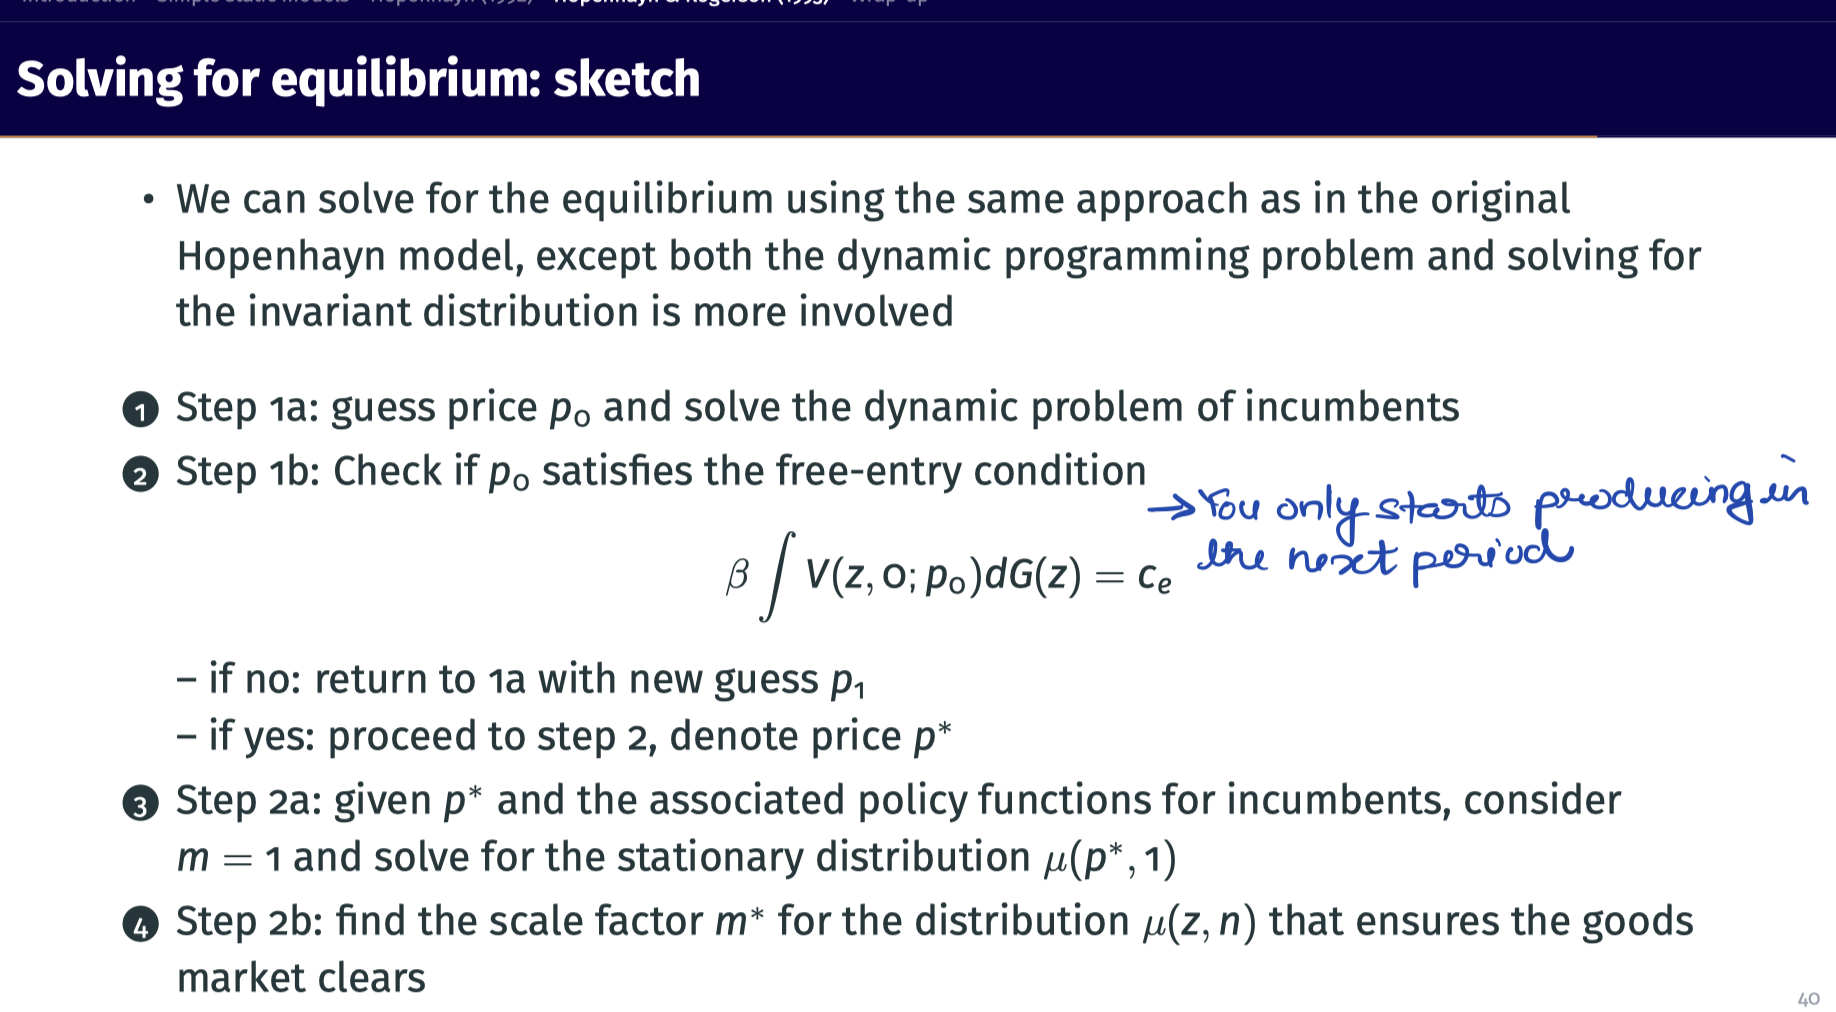



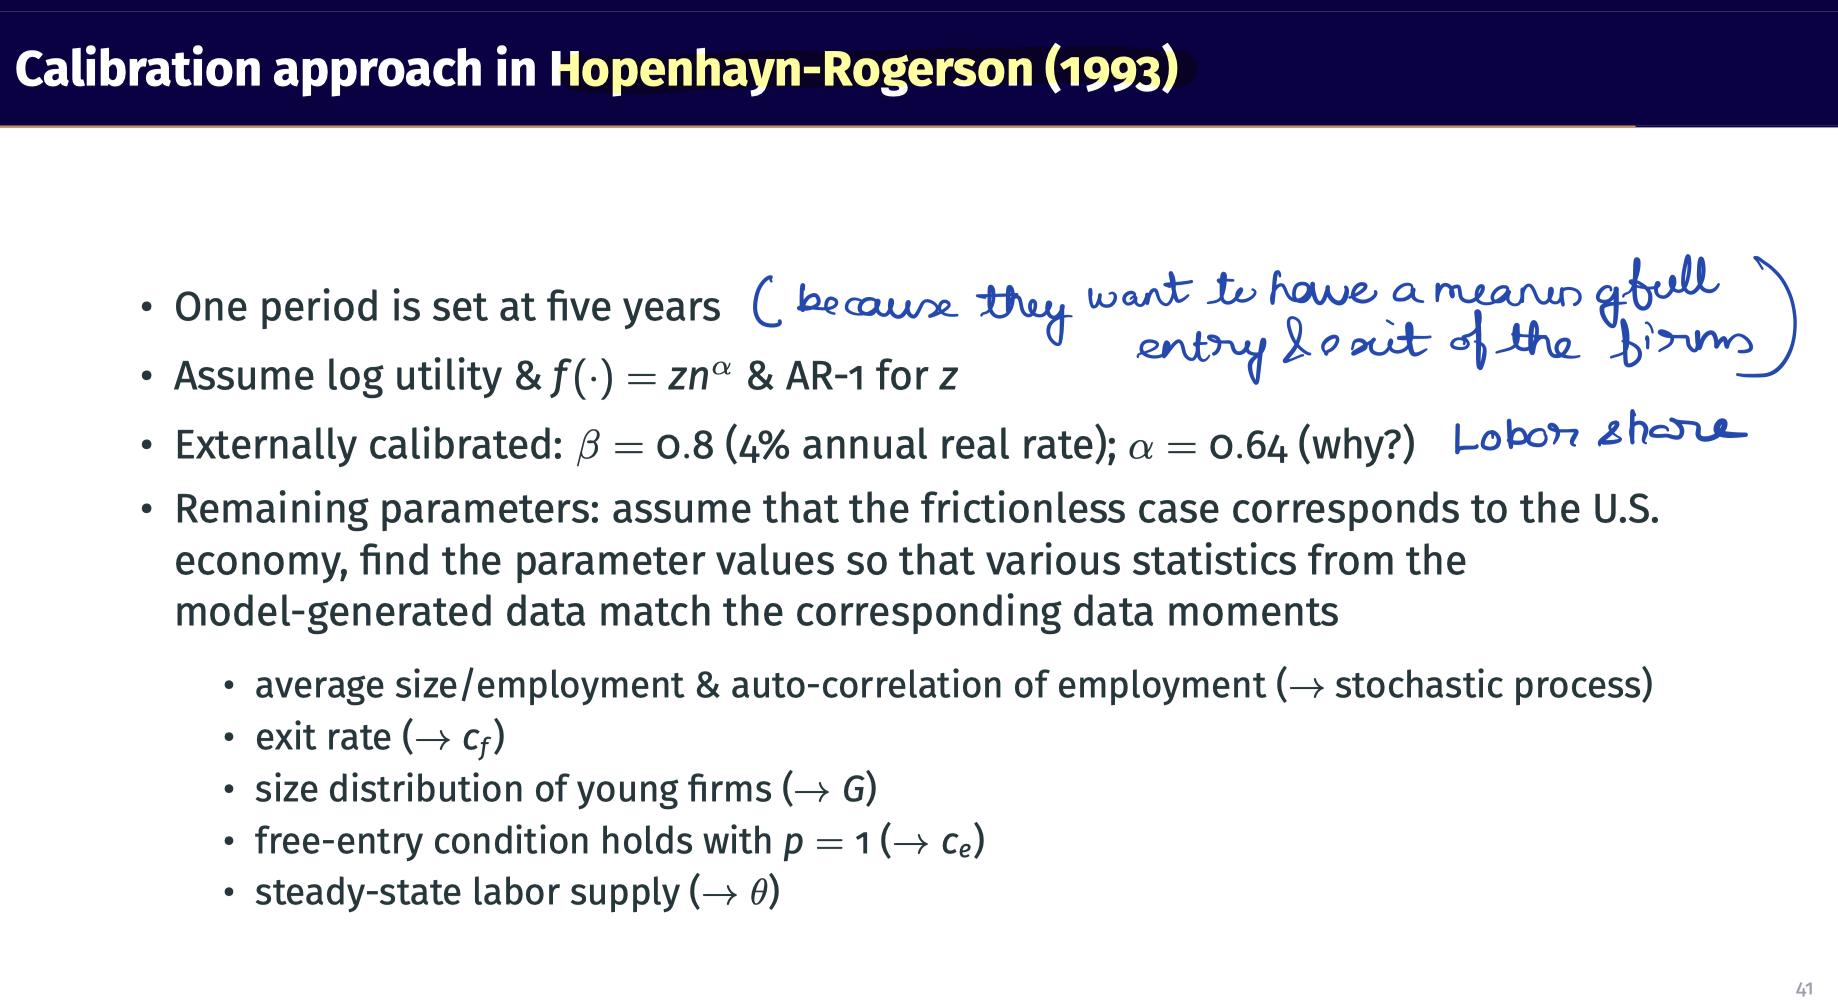



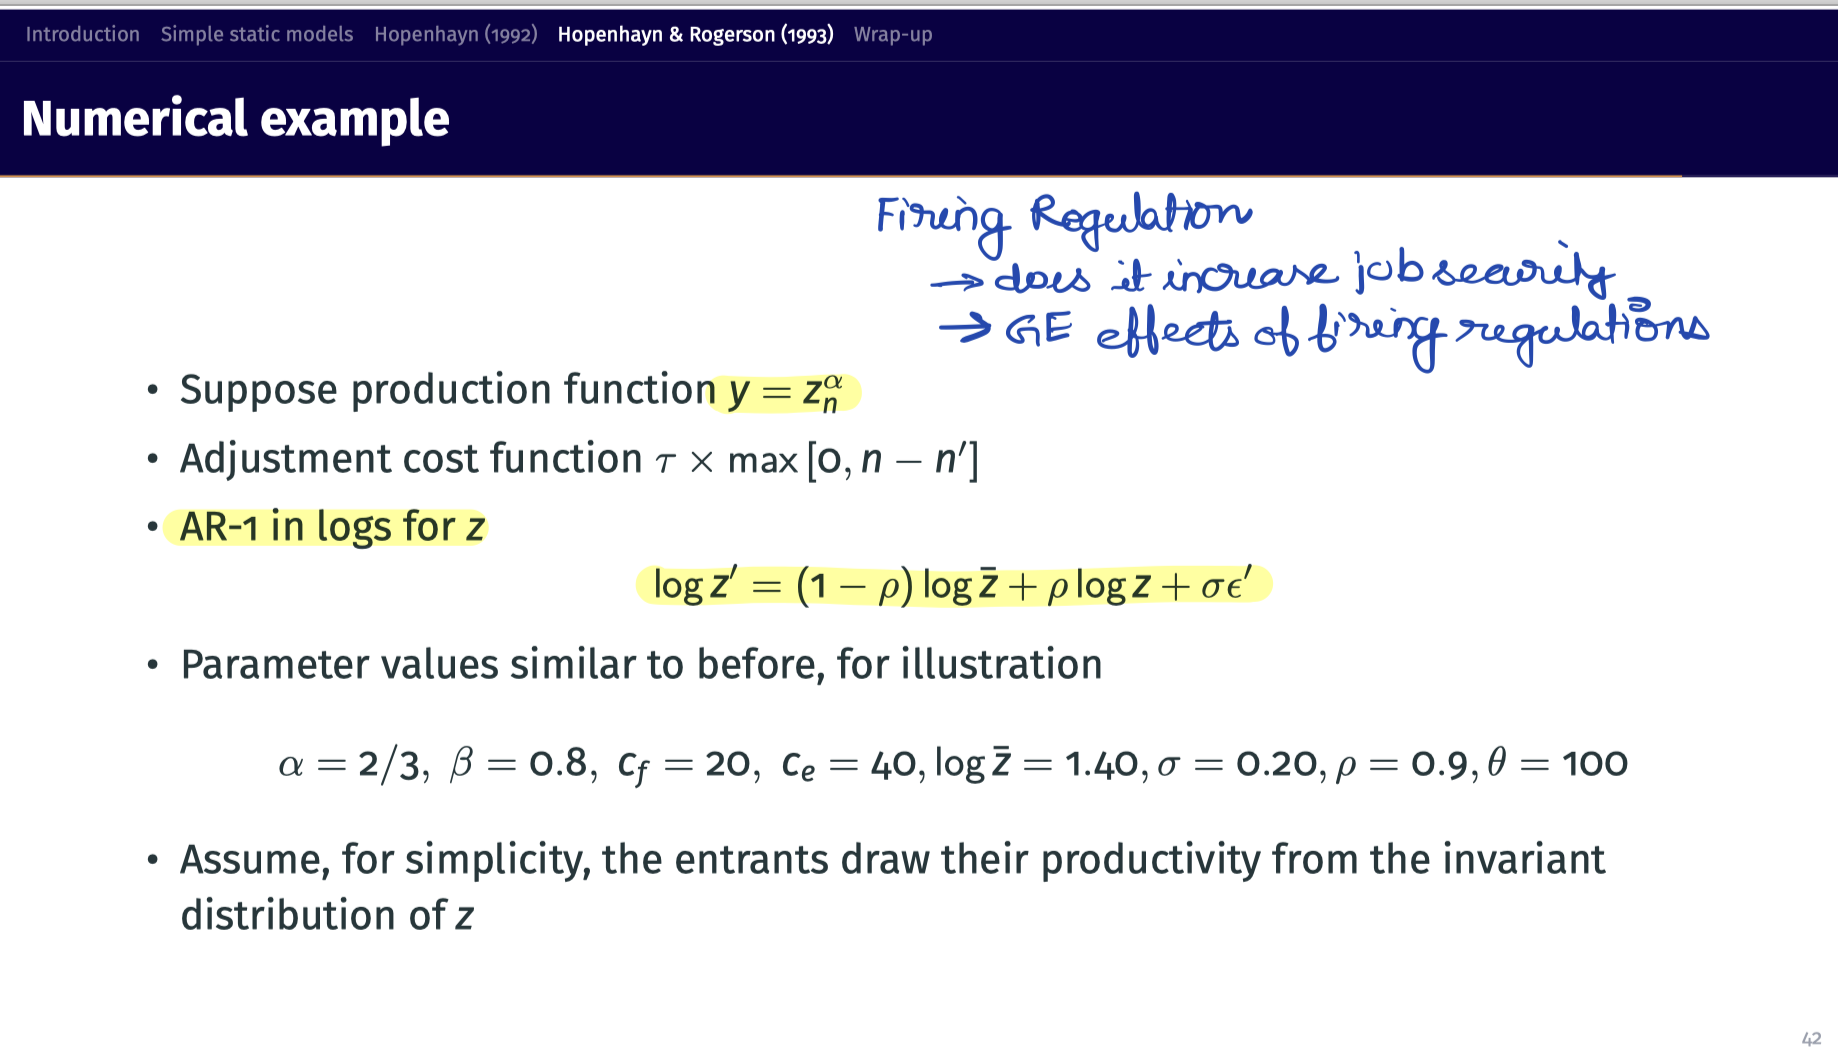



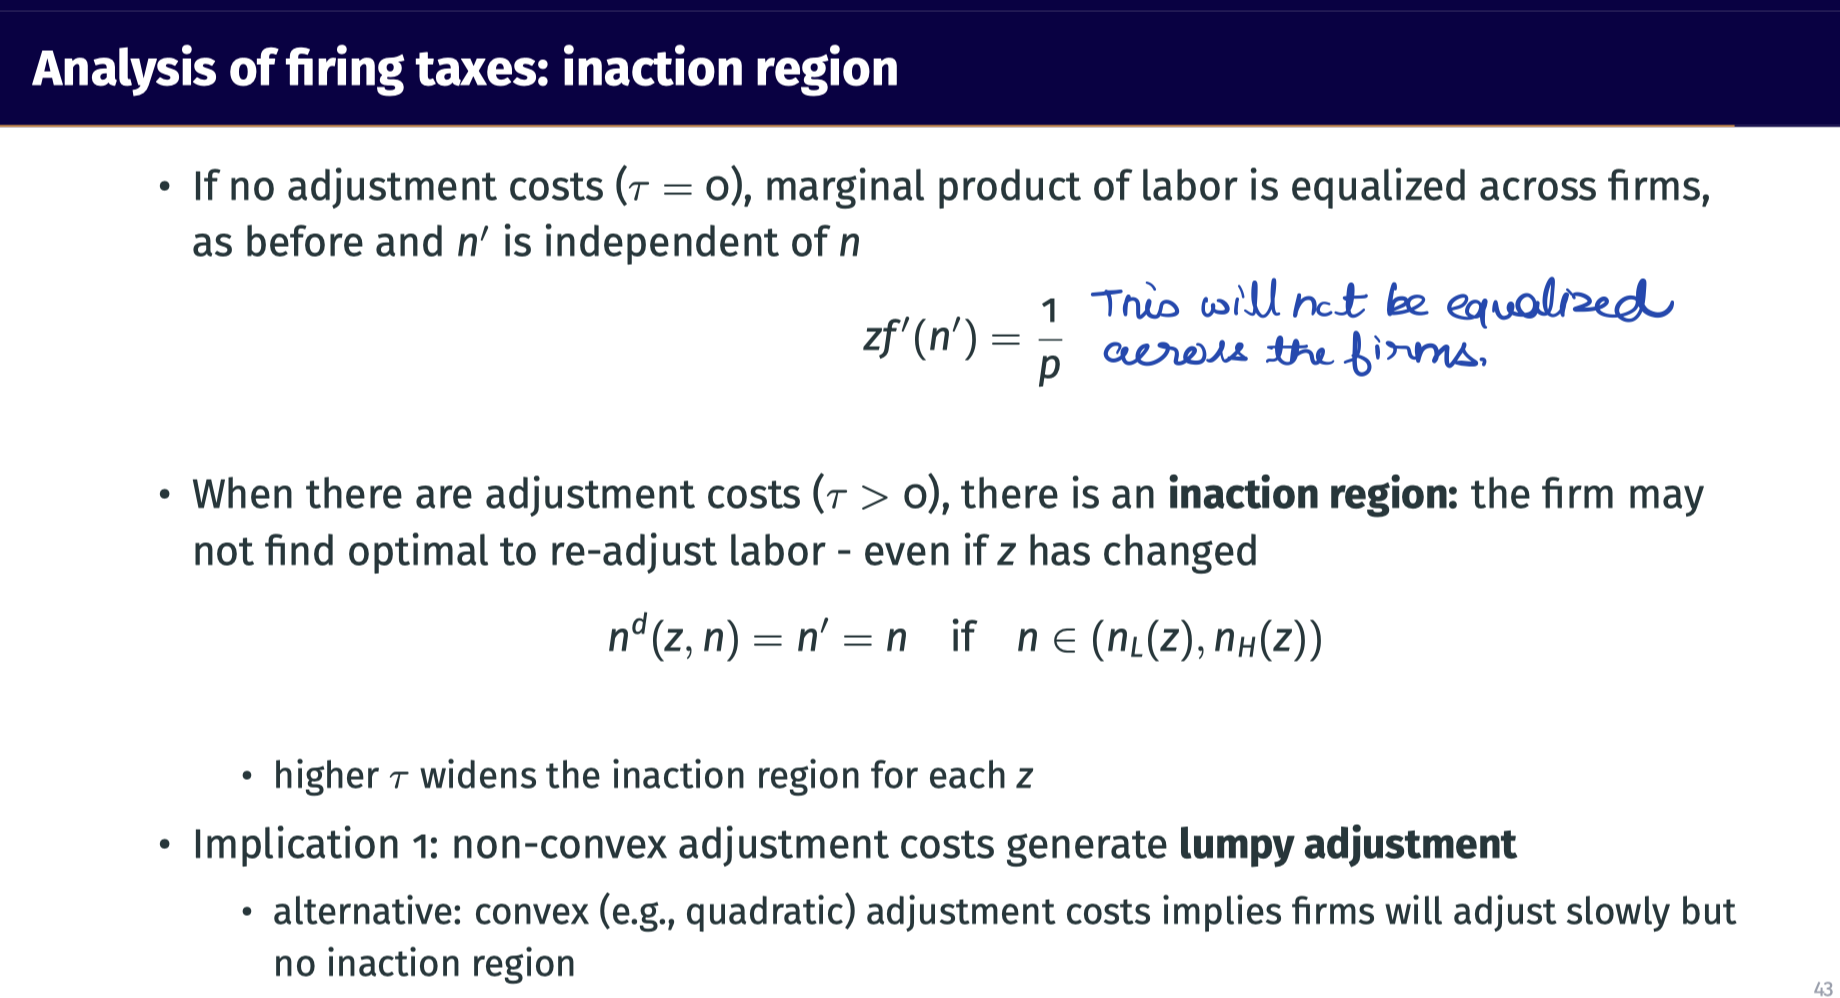



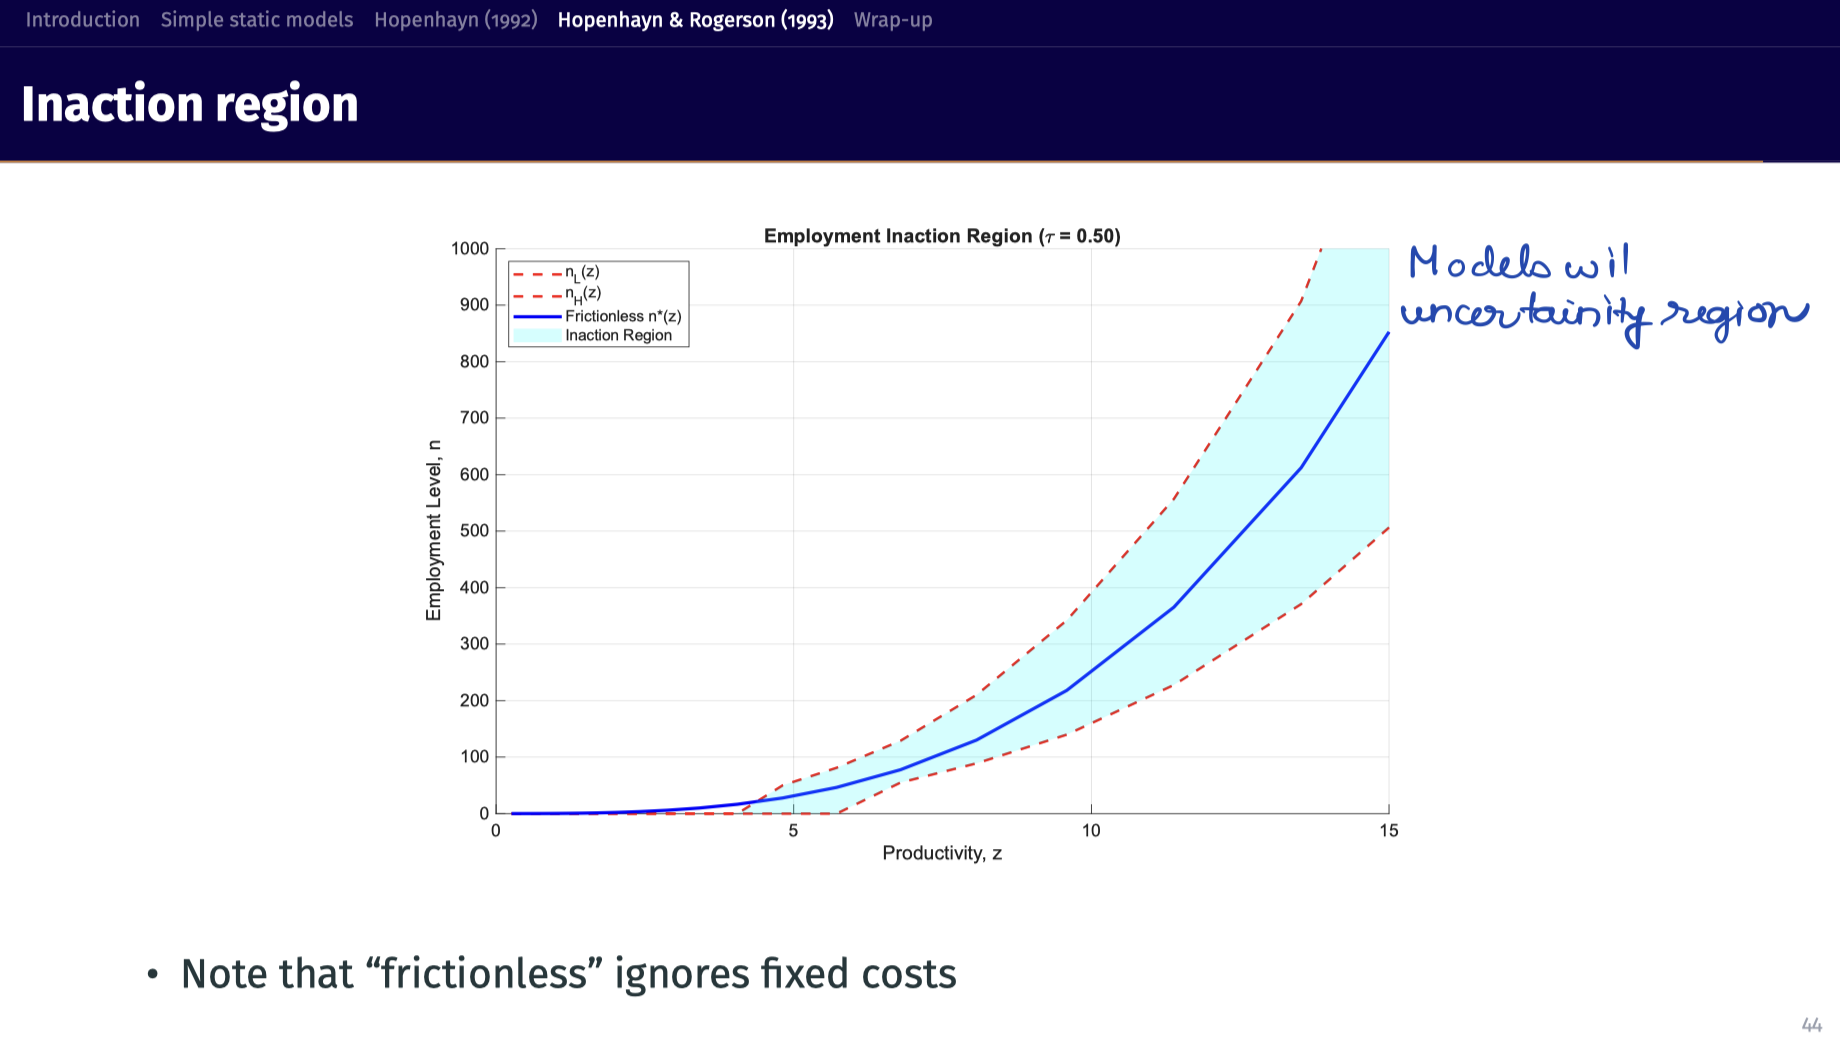



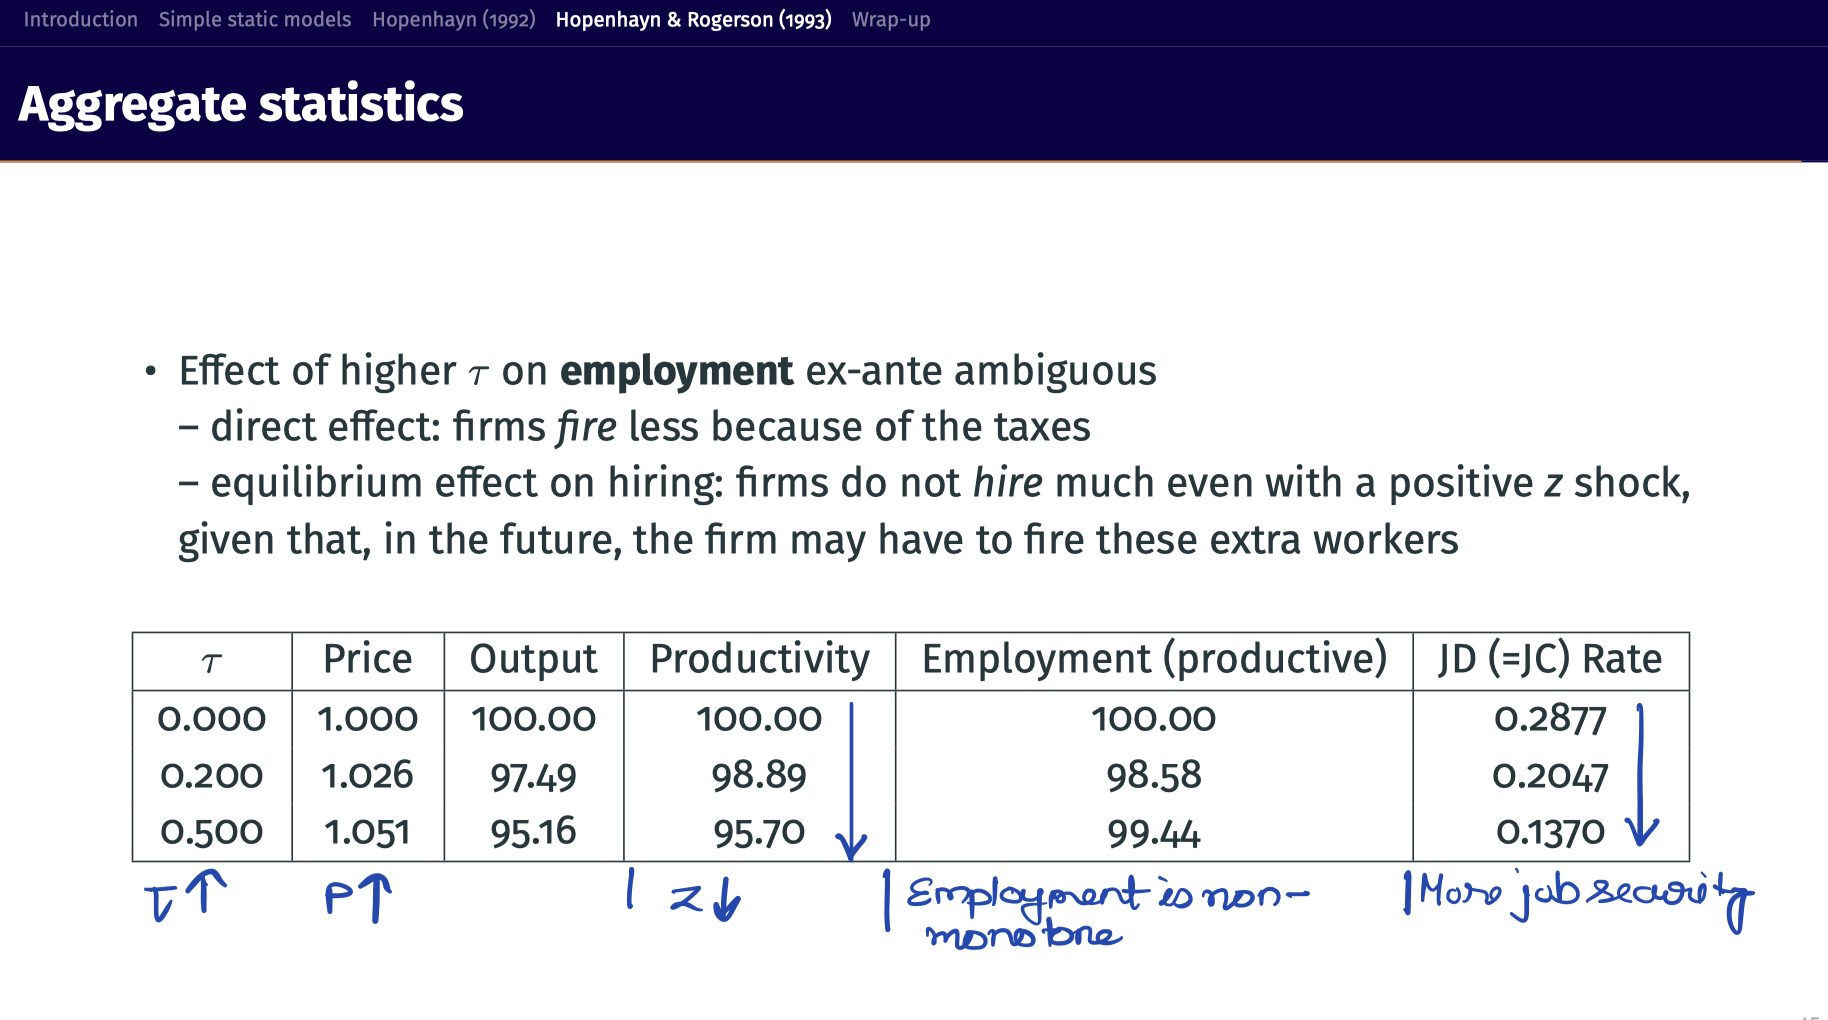





# Hopenhayn 1992 Code

In [1]:
# =========================================================================
# Hopenhayn (1992) Model - Python Implementation
# Translation from MATLAB code by Lukas Freund
# =========================================================================

import numpy as np
from scipy.special import erf
import warnings
import matplotlib.pyplot as plt

# =========================================================================
# Helper Functions
# =========================================================================

def normcdf_local(x):
    """Standard normal CDF without scipy.stats"""
    return 0.5 * (1 + erf(x / np.sqrt(2)))


def fn_tauchen_discrete(n, rho, sigma_eps, mu, m):
    """
    Tauchen (1986) discretization for AR(1) in logs
    log z' = (1-rho)*mu + rho*log z + sigma_eps*eps, eps~N(0,1)
    States on [mu - m*sigma_y, mu + m*sigma_y], where sigma_y^2 = sigma_eps^2/(1-rho^2)
    """
    sigma_y = sigma_eps / np.sqrt(1 - rho**2)
    x = np.linspace(mu - m*sigma_y, mu + m*sigma_y, n)
    step = x[1] - x[0]
    P = np.zeros((n, n))
    
    for i in range(n):
        mu_i = (1 - rho)*mu + rho*x[i]
        
        # Transitioning to the lowest state
        P[i, 0] = normcdf_local((x[0] - mu_i + step/2) / sigma_eps)
        
        # Transitioning to the highest state
        P[i, n-1] = 1 - normcdf_local((x[n-1] - mu_i - step/2) / sigma_eps)
        
        # Interior states
        for j in range(1, n-1):
            zhi = (x[j] + step/2 - mu_i) / sigma_eps
            zlo = (x[j] - step/2 - mu_i) / sigma_eps
            P[i, j] = normcdf_local(zhi) - normcdf_local(zlo)
    
    # Normalize rows to fix numerical drift
    P = P / P.sum(axis=1, keepdims=True)
    
    return x, P


def fn_stationary_row_dist(P, tol=1e-14, maxiter=1000000):
    """Find stationary distribution of Markov chain"""
    n = P.shape[0]
    s = np.ones(n) / n
    it = 0
    
    while it < maxiter:
        it = it + 1
        s_new = np.dot(s, P)
        if np.max(np.abs(s_new - s)) < tol:
            s = s_new
            return s
        s = s_new
    
    warnings.warn("stationary_row_dist: no convergence")
    return s

VFI converged in 20 iterations
VFI converged in 36 iterations
VFI converged in 51 iterations
VFI converged in 64 iterations
VFI converged in 75 iterations
VFI converged in 86 iterations
VFI converged in 94 iterations
VFI converged in 101 iterations
VFI converged in 104 iterations
VFI converged in 109 iterations
VFI converged in 112 iterations
VFI converged in 113 iterations
VFI converged in 113 iterations
VFI converged in 117 iterations
VFI converged in 114 iterations
VFI converged in 116 iterations
VFI converged in 119 iterations
VFI converged in 120 iterations
VFI converged in 118 iterations
VFI converged in 124 iterations
VFI converged in 122 iterations
VFI converged in 122 iterations
VFI converged in 124 iterations
VFI converged in 125 iterations
VFI converged in 128 iterations
VFI converged in 124 iterations
VFI converged in 124 iterations
VFI converged in 127 iterations
VFI converged in 127 iterations
VFI converged in 129 iterations
VFI converged in 128 iterations
VFI converged i

<Figure size 1920x1440 with 0 Axes>

Text(2.0275999834223373, 80, 'z < z*, exit')

(0.0, 8.0)

(-20.0, 100.0)

Text(0.5, 0, 'Productivity, z')

Text(0, 0.5, 'Value function, v(z)')

Text(0.5, 1.0, 'Value Function v(z) and Cutoff Productivity z*')

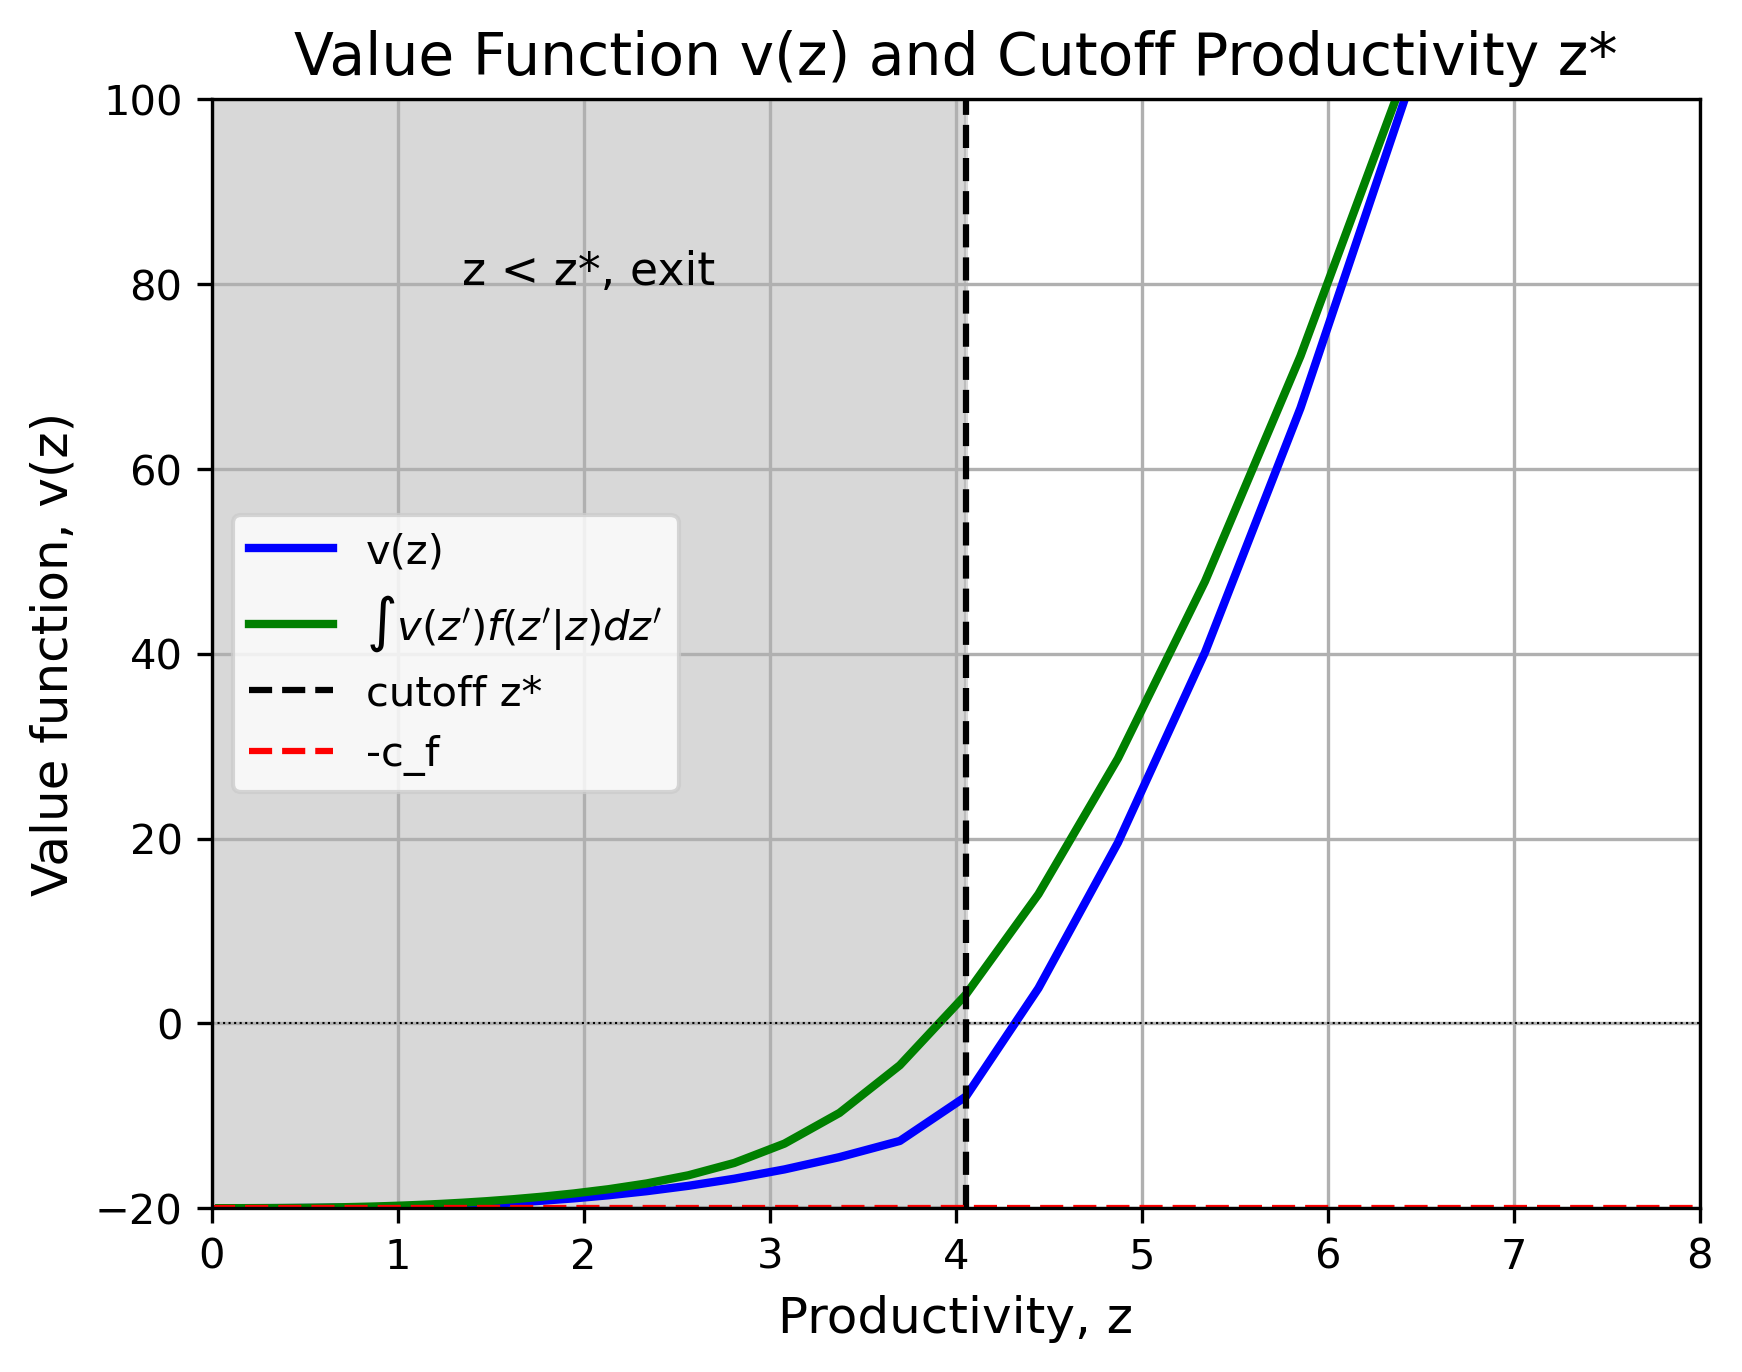

<Figure size 1920x1440 with 0 Axes>

(0.0, 35.0)

(0.0, 0.12)

Text(0.5, 0, 'Productivity, z')

Text(0, 0.5, 'Probability mass')

Text(0.5, 1.0, 'Stationary Distribution')

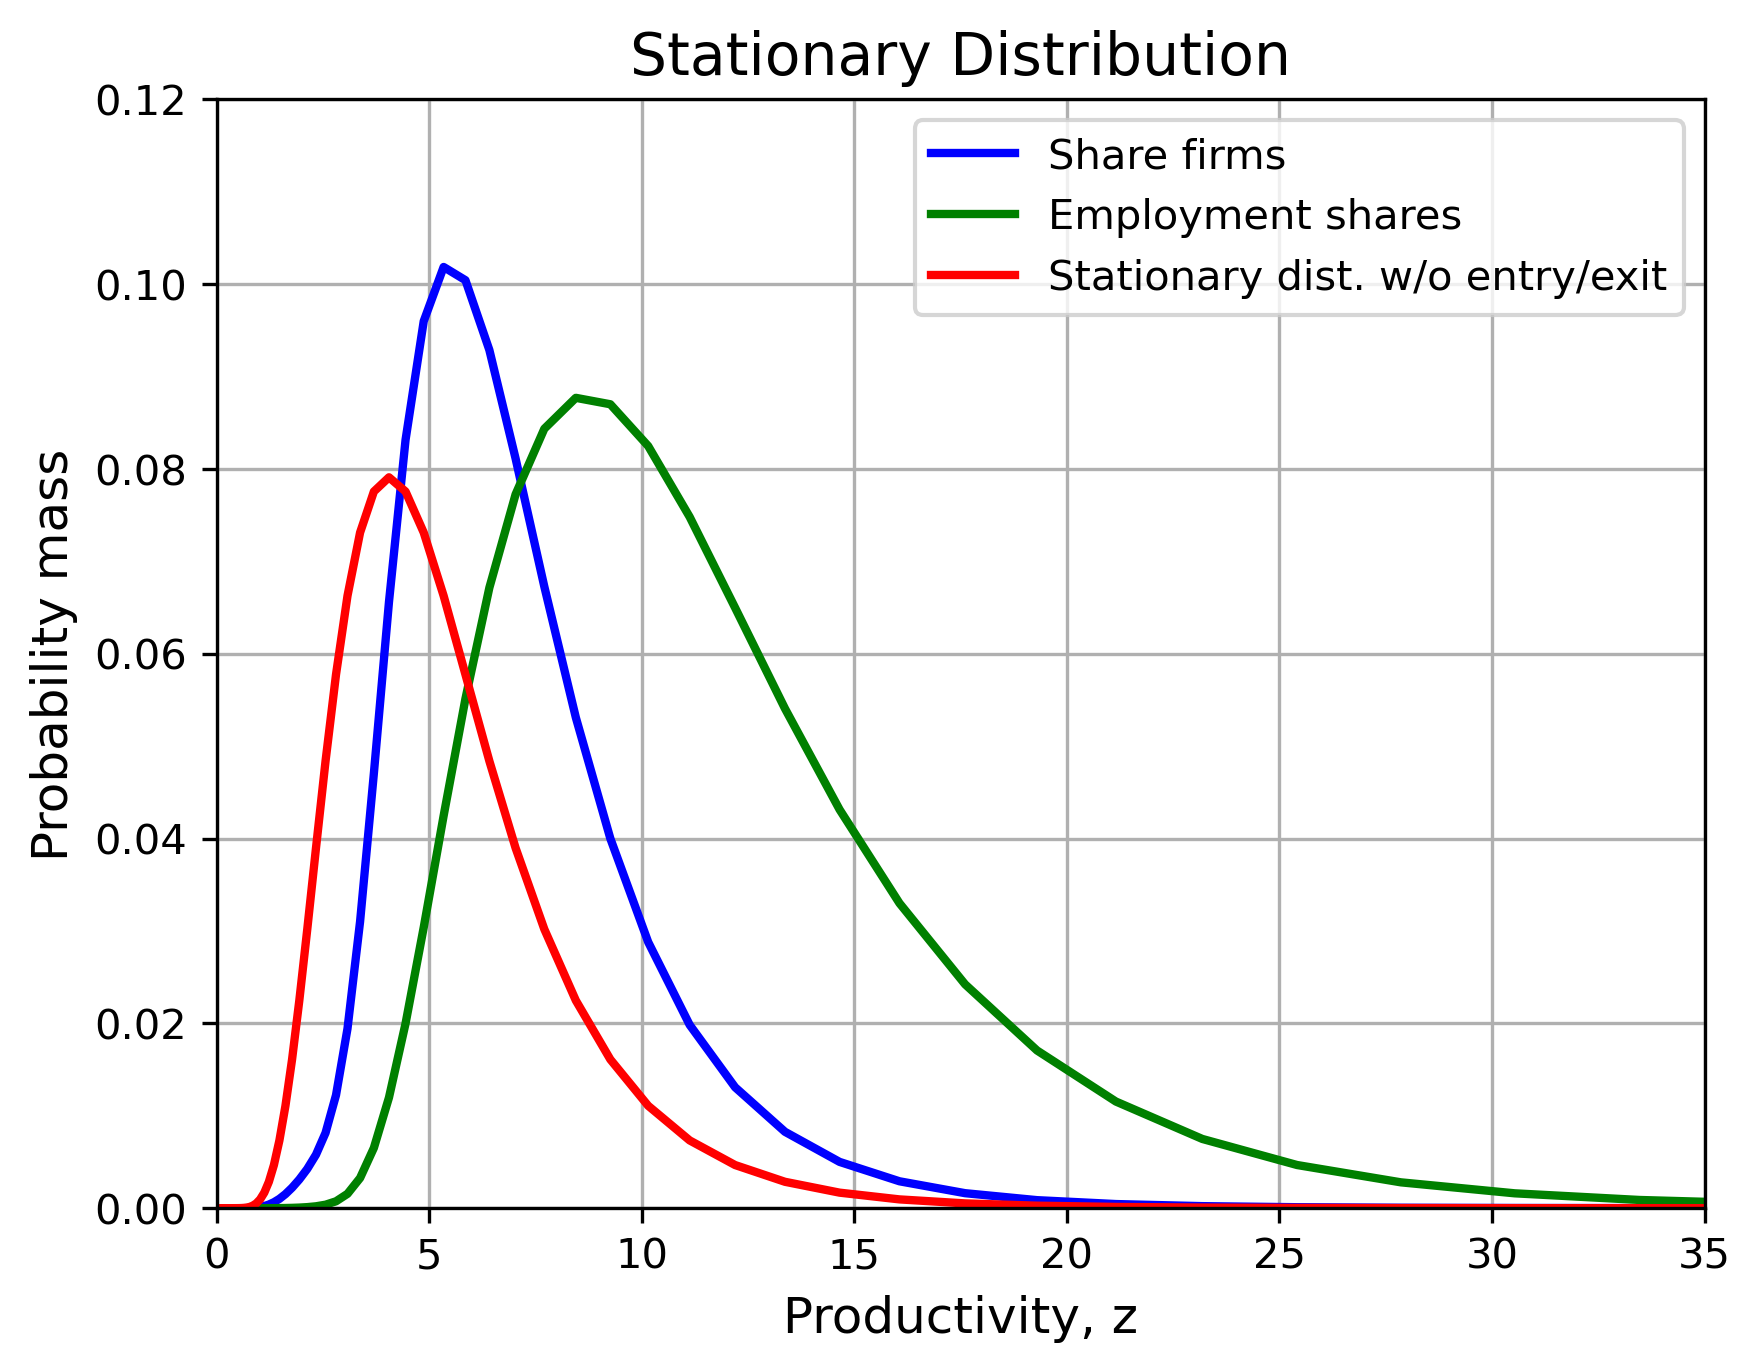


Done! Plots saved.


In [2]:
# =========================================================================
# Hopenhayn Model Class
# =========================================================================

class Hopenhayn:
    """
    Hopenhayn (1992) Model of Industry Dynamics
    """
    
    def __init__(self, 
                 alpha=2/3,           # output elasticity of labor
                 beta=0.8,            # discount factor (5-year period)
                 c_f=20,              # per-period fixed operating cost
                 ce=40,               # sunk entry cost
                 Dbar=100,            # fixed demand
                 zbar_log=1.4,        # mean of log productivity
                 rho=0.9,             # AR(1) persistence in logs
                 sigma_eps=0.2,       # std dev of innovations in log z
                 num_nz=101,          # number of grid points for z
                 num_maxiter_vfi=1000,    # max iterations for VFI
                 num_tol_vfi=1e-8,        # tolerance for VFI
                 num_maxiter_p=100,       # max iterations for price search
                 num_tol_p=1e-10,         # tolerance for price
                 num_sd_gridbound=10,     # number of std devs for grid bounds
                 ):
        
        # Model parameters
        self.alpha = alpha
        self.beta = beta
        self.c_f = c_f
        self.ce = ce
        self.Dbar = Dbar
        
        # AR(1) parameters for productivity
        self.zbar_log = zbar_log
        self.rho = rho
        self.sigma_eps = sigma_eps
        
        # Numerical parameters
        self.num_nz = num_nz
        self.num_maxiter_vfi = num_maxiter_vfi
        self.num_tol_vfi = num_tol_vfi
        self.num_maxiter_p = num_maxiter_p
        self.num_tol_p = num_tol_p
        self.num_sd_gridbound = num_sd_gridbound
        
        # Discretize AR(1) productivity process
        self.logz, self.P = fn_tauchen_discrete(
            self.num_nz, self.rho, self.sigma_eps,
            self.zbar_log, self.num_sd_gridbound
        )
        self.z_grid = np.exp(self.logz)
        
        # Entrants' initial productivity distribution
        self.g = fn_stationary_row_dist(self.P)
    
    def D(self, p):
        """Demand function"""
        return self.Dbar / p
    
    def profit(self, p, z):
        """Static profits calculation"""
        profit_c = (1 - self.alpha) * self.alpha**(self.alpha/(1 - self.alpha))
        return profit_c * (p * z)**(1/(1 - self.alpha)) - self.c_f
    
    def n_policy(self, p, z):
        """Optimal labor policy"""
        return (self.alpha * p * z)**(1/(1 - self.alpha))
    
    def y_policy(self, p, z):
        """Optimal output policy"""
        return z * self.n_policy(p, z)**self.alpha


# =========================================================================
# Value Function Iteration
# =========================================================================

def fn_solve_incumbent_problem(p, hopenhayn, verbose=False):
    """
    Solve incumbent firm's value function via iteration
    """
    nz = len(hopenhayn.z_grid)
    v = np.zeros(nz)
    pi = hopenhayn.profit(p, hopenhayn.z_grid)
    
    for iter in range(hopenhayn.num_maxiter_vfi):
        v_old = v.copy()
        cont_value = np.dot(hopenhayn.P, v_old)
        
        # Bellman equation with exit option
        v = pi + hopenhayn.beta * np.maximum(0, cont_value)
        
        if np.max(np.abs(v - v_old)) < hopenhayn.num_tol_vfi:
            exitflag = 1
            if verbose:
                print(f"VFI converged in {iter} iterations")
            return v, exitflag
    
    exitflag = 0
    warnings.warn("VFI did not converge")
    return v, exitflag


# =========================================================================
# Equilibrium Price Finding
# =========================================================================

def fn_find_price_bounds_coarse(hopenhayn, pL=0.1, pH=10, 
                                 grid_points=50, verbose=True):
    """
    Find rough bounds for equilibrium price via coarse grid search
    """
    p_grid = np.linspace(pL, pH, grid_points)
    ve_vals = np.zeros(grid_points)
    
    for i in range(grid_points):
        p_test = p_grid[i]
        v_test, flag = fn_solve_incumbent_problem(p_test, hopenhayn, verbose)
        ve_vals[i] = hopenhayn.beta * np.sum(v_test * hopenhayn.g)
    
    # Find where ve_vals crosses ce
    idx_cross = np.where(ve_vals >= hopenhayn.ce)[0]
    
    if len(idx_cross) > 0:
        idx_first = idx_cross[0]
        if verbose:
            print(f"First crossing at index {idx_first}, price = {p_grid[idx_first]}")
    else:
        raise ValueError("Entry value never crosses ce. Adjust price bounds.")
    
    # Refine bounds
    if idx_first > 0:
        pL = p_grid[idx_first - 1]
        pH = p_grid[idx_first]
    else:
        pL = p_grid[0]
        pH = p_grid[1]
    
    return ve_vals, p_grid, pL, pH


def fn_find_price_bisection(hopenhayn, pL, pH, verbose=True):
    """
    Find equilibrium price via bisection where entry value = entry cost
    """
    for iter in range(hopenhayn.num_maxiter_p):
        p_star = (pL + pH) / 2
        
        # Solve incumbent problem
        v_star, flag = fn_solve_incumbent_problem(p_star, hopenhayn, verbose)
        
        # Compute entry value
        ve = hopenhayn.beta * np.sum(v_star * hopenhayn.g)
        
        if verbose:
            print(f'Iter {iter:3d}: p = {p_star:.6f}, ve = {ve:.6f}, '
                  f'ce = {hopenhayn.ce:.2f}, gap = {np.abs(ve - hopenhayn.ce):.6f}')
        
        # Check convergence
        if np.abs(ve - hopenhayn.ce) < hopenhayn.num_tol_p:
            if verbose:
                print(f"Converged! Equilibrium Price = {p_star:.6f}")
            price_converge_flag = 1
            return p_star, v_star, price_converge_flag
        elif ve > hopenhayn.ce:
            pH = p_star  # Entry too attractive, lower price
        else:
            pL = p_star  # Entry not attractive enough, raise price
    
    # No convergence
    price_converge_flag = 0
    warnings.warn("Price bisection did not converge")
    return p_star, v_star, price_converge_flag


def fn_find_equilibrium_price(hopenhayn, pL=0.1, pH=10, 
                               grid_points=50, verbose=True):
    """
    Find equilibrium price by combining coarse grid search and bisection
    """
    # Step 1: Find rough bounds
    ve_vals, p_grid, pL, pH = fn_find_price_bounds_coarse(
        hopenhayn, pL, pH, grid_points, verbose
    )
    
    # Step 2: Refine with bisection
    p_star, v_star, price_converge_flag = fn_find_price_bisection(
        hopenhayn, pL, pH, verbose
    )
    
    return p_star, v_star, price_converge_flag


# =========================================================================
# Exit Threshold
# =========================================================================

def fn_find_zstar(hopenhayn, v_star, p_star):
    """
    Find exit threshold z* where continuation value equals zero
    
    Parameters:
        hopenhayn: Hopenhayn model instance
        v_star: Value function at equilibrium price (nz,)
        p_star: Equilibrium price
        
    Returns:
        z_star: Exit threshold productivity level
        idx_exit: Index of exit threshold
        cont_value: Continuation value for all states (nz,)
    """
    # Calculating the continuation value
    cont_value = np.dot(hopenhayn.P, v_star)

    # Finding at which productivity level is the continuation value positive
    idx_continue = np.where(cont_value >= 0)[0]
    
    if len(idx_continue) > 0:
        # Picking the first element
        idx_exit = idx_continue[0]

        # Finding z_star as the first z value at which the cont_value > 0
        z_star = hopenhayn.z_grid[idx_exit]

        # print
        print(f'Exit Threshold z* = {z_star:.4f}, and index = {idx_exit:3d}')
        return z_star, idx_exit, cont_value
    
    warnings.warn("No exit threshold found: continuation value is negative for all z")
    return None, None, cont_value


# =========================================================================
# Stationary Distribution
# =========================================================================

def fn_stationary_distribution(hopenhayn, idx_exit):
    """
    Compute stationary distribution of firms accounting for entry and exit.

    Parameters:
        hopenhayn: Hopenhayn model instance
        idx_exit: Index of exit threshold (firms below this exit)
        
    Returns:
        Phi: Transition matrix with exit (nz x nz)
        mu_normalized: Stationary distribution for mass m=1 of entrants (nz,)
    """

    ## Creating the Transition Matrix

    # Finding the z_grid where the continuation value is positive
    survival_mask = np.arange(hopenhayn.num_nz) >= idx_exit  # [False, True, True, ...]

    # Taking the transpose of the transition matrix and zero out the columns for exit states (below idx_exit)
    # This is needed as Phi counts flow into state i (in row), whereas P counts flows from state i (in row) 
    Phi = hopenhayn.P.T * survival_mask

    # Broadcasting example for Phi = P.T * survival_mask
    # 
    # Assume P (3x3) and idx_exit = 1 (state 0 exits, states 1,2 survive):
    # P = [[0.7, 0.2, 0.1],
    #      [0.3, 0.5, 0.2],
    #      [0.1, 0.3, 0.6]]
    #
    # P.T = [[0.7, 0.3, 0.1],
    #        [0.2, 0.5, 0.3],
    #        [0.1, 0.2, 0.6]]
    #
    # survival_mask = [False, True, True]  # shape (3,)
    #
    # P.T * survival_mask broadcasts mask across rows:
    # Row 0: [0.7, 0.3, 0.1] * [0, 1, 1] = [0.0, 0.3, 0.1]
    # Row 1: [0.2, 0.5, 0.3] * [0, 1, 1] = [0.0, 0.5, 0.3]
    # Row 2: [0.1, 0.2, 0.6] * [0, 1, 1] = [0.0, 0.2, 0.6]
    #
    # Result: Column 0 is zeroed (exit state), columns 1-2 preserved
    
    # Creating Stationary distribution mu_normalized = (I - Phi) \ g
    I = np.eye(hopenhayn.num_nz)
    mu_normalized = np.linalg.solve(I - Phi, hopenhayn.g)

    return Phi, mu_normalized


# Intuition for sum of mu_normalized:
# 
# Think of firms like water in a bathtub in steady state:
# - Inflow: m=1 firm enters per period
# - Outflow: firms exit when productivity too low
# - Stock: mu_normalized tells how many firms in each state
#
# sum(mu_normalized) = 7.28 means:
# "At any moment, there are 7.28 firms alive on average"
#
# Since 1 firm enters per period, and 7.28 firms exist on average,
# each firm survives approximately 7.28 periods before exiting.
#
# Bathtub analogy:
# If water flows in at 1 liter/min, and tub holds 7.28 liters 
# in steady state, then each liter stays 7.28 minutes on average.


# =========================================================================
# Market Clearing
# =========================================================================

def fn_compute_equilibrium(hopenhayn, mu_normalized, p_star):
    """
    Find mass of entrants that clears the market and compute equilibrium objects.

    Market clearing: D(p*) = m* × Y_normalized
    where Y_normalized is total output when m=1

    Parameters:
        hopenhayn: Hopenhayn model instance
        mu_normalized: Stationary distribution for m=1 (nz,)
        p_star: Equilibrium price
        
    Returns:
        m_star: Mass of entrants that clears market
        mu_star: Actual stationary distribution (m_star × mu_normalized)
        Y_normalized: Total output when m=1
        employment: Per-firm employment at each productivity level (nz,)
        emp_dist: Employment shares across productivity levels (nz,), sums to 1
    """

    # Total output when m=1 entrant per period
    Y_normalized = np.sum(hopenhayn.y_policy(p_star, hopenhayn.z_grid) * mu_normalized)

    # Market demand at equilibrium price
    D_market = hopenhayn.D(p_star)

    # Mass of entrants needed to clear market: D(p*) = m* × Y_normalized
    m_star = D_market / Y_normalized

    # Scale up distribution to actual equilibrium mass
    mu_star = m_star * mu_normalized

    # Finding the employment for at price p_star across all the z_grids
    employment = hopenhayn.n_policy(p_star, hopenhayn.z_grid)

    # Total employment in each state
    emp_total = employment * mu_star

    # Employment shares (normalized to sum to 1)
    emp_dist = emp_total / emp_total.sum()

    return m_star, mu_star, Y_normalized, employment, emp_dist


# =========================================================================
# Main Execution
# =========================================================================

# Create model instance
hh = Hopenhayn()

# Find equilibrium price
p_star, v_star, _ = fn_find_equilibrium_price(hh, verbose=True)

# Find exit threshold
z_star, idx_exit, cont_value = fn_find_zstar(hh, v_star, p_star)

# Compute stationary distribution
Phi, mu_normalized = fn_stationary_distribution(hh, idx_exit)
print(f"Sum of mu_normalized: {mu_normalized.sum():.6f}")

# Compute market equilibrium
m_star, mu_star, y_star, emp, emp_dist = fn_compute_equilibrium(hh, mu_normalized, p_star)

# =========================================================================
# Summary Results
# =========================================================================

print("=" * 50)
print("Equilibrium Results")
print(f'Price p* = {p_star:.6f}')
print(f'Exit threshold z* = {z_star:.4f}')
print(f'Mass of entrants m* = {m_star:.4f}')
print(f'Entry value = {hh.beta * np.sum(v_star * hh.g):.4f} (should equal ce = {hh.ce:.2f})')




# =========================================================================
# Plots
# =========================================================================

# Plot 1: Value Function and Exit Threshold
plt.figure(dpi=300)
plt.plot(hh.z_grid, v_star, 'b-', linewidth=2, label="v(z)")
plt.plot(hh.z_grid, cont_value, 'g-', linewidth=2, label=r"$\int v(z')f(z'|z)dz'$")
plt.axvline(z_star, color='k', linestyle='--', linewidth=1.5, label='cutoff z*')
plt.axhline(-hh.c_f, color='r', linestyle='--', linewidth=1.5, label='-c_f')
plt.axhline(0, color='black', linestyle=':', linewidth=0.5)
plt.fill_between([0, z_star], -20, 100, color='gray', alpha=0.3)
plt.text(z_star/2, 80, 'z < z*, exit', fontsize=11, ha='center')
plt.xlim([0, 8])
plt.ylim([-20, 100])
plt.xlabel('Productivity, z', fontsize=12)
plt.ylabel('Value function, v(z)', fontsize=12)
plt.title('Value Function v(z) and Cutoff Productivity z*', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True)
plt.savefig('hopenhayn_value_function.pdf', bbox_inches='tight')
plt.show()




# Plot 2: Stationary Distribution
# Computing the baseline stationary distribution (without entry/exit)
eigenvalues, eigenvectors = np.linalg.eig(hh.P.T)
idx_stat = np.argmax(eigenvalues)
f_bar = eigenvectors[:, idx_stat].real  # Take real part to avoid numerical noise
f_bar = f_bar / f_bar.sum()

plt.figure(dpi=300)
plt.plot(hh.z_grid, mu_star / mu_star.sum(), 'b-', linewidth=2, label="Share firms")
plt.plot(hh.z_grid, emp_dist, 'g-', linewidth=2, label="Employment shares")
plt.plot(hh.z_grid, f_bar, 'r-', linewidth=2, label="Stationary dist. w/o entry/exit")
plt.xlim([0, 35])
plt.ylim([0, 0.12])
plt.xlabel('Productivity, z', fontsize=12)
plt.ylabel('Probability mass', fontsize=12)
plt.title('Stationary Distribution', fontsize=14)
plt.legend(loc='best')
plt.grid(True)
plt.savefig('hopenhayn_stationary_distribution.pdf', dpi =300, bbox_inches='tight')
plt.show()

print("\nDone! Plots saved.")

## HR Class code

In [3]:

# =========================================================================
# Hopenhayn Rogerson 19923 Model Class
# =========================================================================

class HopenhaynRogerson:
    """
    Hopenhayn (1992) Model of Industry Dynamics
    """
    
    def __init__(self, 
                 alpha=2/3,           # output elasticity of labor
                 beta=0.8,            # discount factor (5-year period)
                 c_f=20,              # per-period fixed operating cost
                 ce=40,               # sunk entry cost
                 Dbar=100,            # fixed demand
                 zbar_log=1.4,        # mean of log productivity
                 rho=0.9,             # AR(1) persistence in logs
                 sigma_eps=0.2,       # std dev of innovations in log z
                 theta = 100,           # consumer utility parameter
                 tau = 0.2,             # Government tax rate to rebate
                 num_nz=101,          # number of grid points for z
                 num_nemp= 500,         # Employment Grid Points
                 num_maxiter_vfi=1000,    # max iterations for VFI
                 num_tol_vfi=1e-8,        # tolerance for VFI
                 num_maxiter_p=100,       # max iterations for price search
                 num_tol_p=1e-10,         # tolerance for price
                 num_sd_gridbound=10,     # number of std devs for producitivity tauchen discretization
                 num_sd_empgridbound = 1.5 # To have some leeway to be outside the max productivity bound
                 ):
        
        # Model parameters
        self.alpha = alpha
        self.beta = beta
        self.c_f = c_f
        self.ce = ce
        self.Dbar = Dbar
        self.theta = theta
        self.tau = tau
        
        
        # AR(1) parameters for productivity
        self.zbar_log = zbar_log
        self.rho = rho
        self.sigma_eps = sigma_eps
        
        # Numerical parameters
        self.num_nz = num_nz
        self.num_maxiter_vfi = num_maxiter_vfi
        self.num_tol_vfi = num_tol_vfi
        self.num_maxiter_p = num_maxiter_p
        self.num_tol_p = num_tol_p
        self.num_sd_gridbound = num_sd_gridbound
        self.num_nemp = num_nemp
        self.num_sd_empgridbound = num_sd_empgridbound
        
        # Discretize AR(1) productivity process
        self.logz, self.P = fn_tauchen_discrete(
            self.num_nz, self.rho, self.sigma_eps,
            self.zbar_log, self.num_sd_gridbound
        )
        self.z_grid = np.exp(self.logz)
        
        # Entrants' initial productivity distribution
        self.g = fn_stationary_row_dist(self.P)
    
    # def D(self, p):
    #     """Demand function"""
    #     return self.Dbar / p
    
    def labor_adjustment_cost(self,n_new, n_old):
        return self.tau * np.maximum(0, n_old - n_new)
    
    # With Adjusment Costs
    def profit(self, p, z, n_old, n_new):
        """Static profits calculation"""
        return p*z*n_new**self.alpha - n_new - self.labor_adjustment_cost(n_new, n_old) - self.c_f 

    # Optimal policy without any adjusment costs
    def n_nofriction_policy(self, p, z):
        """Optimal Frictionless labor policy"""
        return (self.alpha * p * z)**(1/(1 - self.alpha))
    




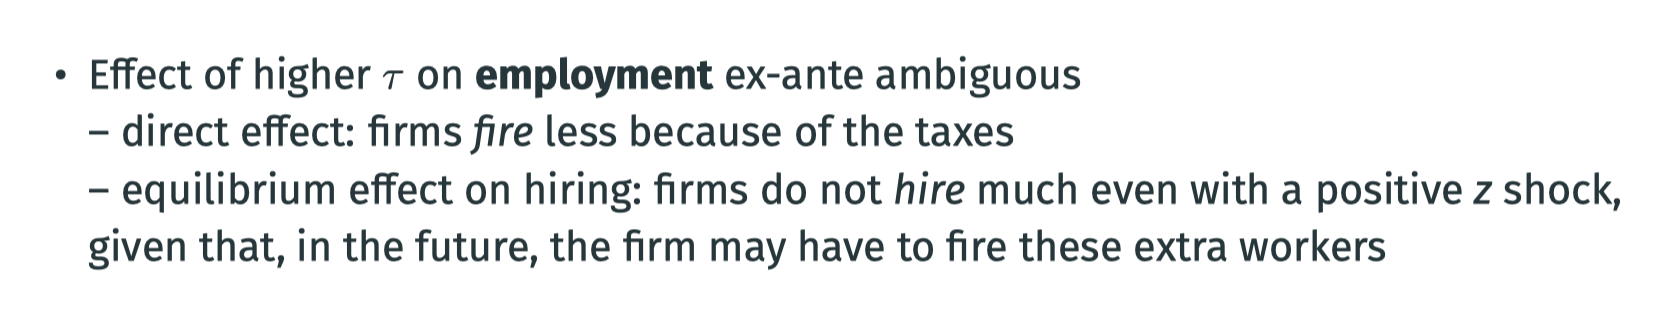


## Bellman Function

In [9]:
def fn_solve_incumbent_problem_hr(p, hr, verbose = False):
    """
    Solve incumbents firms value function ar

    # Input
    p = price
    hr = Hopenhayn Rogerson Class
    
    """

    # Finding the employment grid based upon the n_nofriction_policy
    hr.emp_grid = np.linspace(0, hr.num_sd_empgridbound * hr.n_nofriction_policy(p, hr.z_grid[-1]), hr.num_nemp)

    # Intializing the value function at 0 for all the combination of emp and z
    V = np.zeros((hr.num_nz, hr.num_nemp))

    # Intializing the policy funtion at 0
    n_policy = np.zeros((hr.num_nz, hr.num_nemp))

    # Defining the bellman iterations
    for iter in range(hr.num_maxiter_vfi):
        
        # Storing old value
        V_old = V.copy()

        # Computing the continuation values
        # hr. P is num_nz x num_nz and V is num_nz x num_nemp. Thus (i,j) element in PV denotes the expected the payoff in state i with next period capital to be j
        cont_value_matrix = np.dot(hr.P, V)

        # Finding the optimal policy at each combinaiton of z and n
        for i, z in enumerate(hr.z_grid):
            for j, n_old in enumerate(hr.emp_grid):
               
                # Computing the Exit Value
                exit_value = -hr.labor_adjustment_cost(n_new = 0, n_old = n_old)
                
                # Calculation Profit at all num_emp choices
                profit_vec = hr.profit(p, z , n_old ,hr.emp_grid)

                # Defining the objective function, where each element denotes the V at n_new
                objective = profit_vec + hr.beta * cont_value_matrix[i, :]
                
                
                # Choosing the best_valuation profit
                best_n_new_index = np.argmax(objective)
                best_continuation = objective[best_n_new_index]


                # Reassigning the Value Function and Policy Function
                V[i, j] = np.maximum(exit_value, best_continuation)
                n_policy[i,j] = 0 if exit_value > best_continuation else hr.emp_grid[best_n_new_index]

        
        # Comparing the new vs old value function
        if np.max(np.abs(V - V_old)) < hr.num_tol_vfi:
            exitflag = 1
            if verbose:
                print(f'VFI converged in {iter} iterations')
            return V,n_policy, exitflag

        if verbose:
            if iter % 10 == 0:  # Print every 10 iterations
                max_diff = np.max(np.abs(V - V_old))
                print(f"Iter {iter}: max diff = {max_diff:.6e}")


    # If not convergence 
    exitflag = 0
    warnings.warn("VFI did not converge")
    return V, n_policy, exitflag


    
    # return hr.emp_grid


In [10]:
import time

start = time.time()
V, n_policy, flag = fn_solve_incumbent_problem_hr(1, hr, verbose=True)
elapsed = time.time() - start
print(f"VFI took {elapsed:.2f} seconds")

Iter 0: max diff = 3.813544e+04
Iter 10: max diff = 3.249516e+01
Iter 20: max diff = 4.241848e-01
Iter 30: max diff = 1.005215e-02
Iter 40: max diff = 2.622996e-04
Iter 50: max diff = 6.917995e-06
Iter 60: max diff = 1.826702e-07
VFI converged in 68 iterations
VFI took 12.62 seconds


In [11]:
import pandas as pd
V_df = pd.DataFrame(V, 
                    index=np.round(hr.z_grid, 2),
                    columns=np.round(hr.emp_grid, 0))
print(V_df)


           0.0           229.0         459.0         688.0         918.0     \
0.26      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.30      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.35      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.41      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.48      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.57      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.66      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.78      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
0.91      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
1.06      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
1.25      -0.000000    -45.878298    -91.756596   -137.634894   -183.513192   
1.46      -0.000000    -45.878298    -91.756596   -1

In [12]:
def fn_find_price_bounds_coarse_hr(hr, pL = 0.1, pH = 10, grid_points = 50, verbose = True):
    """
    Finding the rough bounds for the HR Model
    """
    p_grid = np.linspace(pL, pH, grid_points)
    ve_vals = np.zeros(grid_points)
    
    for i in range(grid_points):
        p_test = p_grid[i]
        v_test, flag = fn_solve_incumbent_problem(p_test, hopenhayn, verbose)
        ve_vals[i] = hopenhayn.beta * np.sum(v_test * hopenhayn.g)
    
    # Find where ve_vals crosses ce
    idx_cross = np.where(ve_vals >= hopenhayn.ce)[0]
    
    if len(idx_cross) > 0:
        idx_first = idx_cross[0]
        if verbose:
            print(f"First crossing at index {idx_first}, price = {p_grid[idx_first]}")
    else:
        raise ValueError("Entry value never crosses ce. Adjust price bounds.")
    
    # Refine bounds
    if idx_first > 0:
        pL = p_grid[idx_first - 1]
        pH = p_grid[idx_first]
    else:
        pL = p_grid[0]
        pH = p_grid[1]
    
    return ve_vals, p_grid, pL, pH


In [13]:
# Definig the HopenhaynRogerson Class
hr = HopenhaynRogerson(num_nz = 5, num_sd_gridbound= 6, num_nemp=5)

In [14]:
# Definig the HopenhaynRogerson Class
hr = HopenhaynRogerson(num_nz = 36, num_sd_gridbound= 6, num_nemp=500)

In [15]:
V_test, n_policy_test, flagtest = fn_solve_incumbent_problem_hr(1, hr, verbose = True)

Iter 0: max diff = 3.813544e+04
Iter 10: max diff = 3.249516e+01
Iter 20: max diff = 4.241848e-01
Iter 30: max diff = 1.005215e-02
Iter 40: max diff = 2.622996e-04
Iter 50: max diff = 6.917995e-06
Iter 60: max diff = 1.826702e-07
VFI converged in 68 iterations


In [ ]:
# # Definig the HopenhaynRogerson Class
hr = HopenhaynRogerson(num_nz = 5, num_sd_gridbound= 6, num_nemp=5)

In [16]:
import time

start = time.time()
V, n_policy, flag = fn_solve_incumbent_problem_hr(1, hr, verbose=True)
elapsed = time.time() - start
print(f"VFI took {elapsed:.2f} seconds")

Iter 0: max diff = 3.813544e+04
Iter 10: max diff = 3.249516e+01
Iter 20: max diff = 4.241848e-01
Iter 30: max diff = 1.005215e-02
Iter 40: max diff = 2.622996e-04
Iter 50: max diff = 6.917995e-06
Iter 60: max diff = 1.826702e-07
VFI converged in 68 iterations
VFI took 11.99 seconds
